# Automated Model Discovery for Heart Tissue


Heart Data Reference: http://www.sciencedirect.com/science/article/pii/S1742706115300039

Code by Denisa Martonová & Skyler St. Pierre & Kevin Linka \\
Last edited May 2024

## Problem description

A hyperelastic or Green-elastic materials with can directly be defined by the Piola stress
$$
  \mathbf{P}
= \frac{\partial \psi (\mathbf{F})}{\partial \mathbf{F}} \,,
$$
in dependency of the strain energy function $\Psi$ and the deforation gradient $\mathbf{F}$. Now, by contraining the material symmetry to the special case of isotropy, the strain energy function can be given as a function of the first three strain invariants as $\Psi(I_1, \, I_2,\, I_{4f},...I_{8sn}).$


We can further constrain the choice of the free energy function $\psi$ for the special case of perfect incompressibility for which the Jacobian remains constant and equal to one, $I_3 = 1$. So we obtain for the Piola stress tensor
$$
  \mathbf{P}
= \frac{\partial \psi}{\partial I_1} \frac{\partial I_1}{\partial \mathbf{F}}
+ \frac{\partial \psi}{\partial I_2} \frac{\partial I_2}{\partial \mathbf{F}} + ...
- p\, \mathbf{F}^{\rm {-t}} .     
$$




### 0. Load python packages

In [ ]:
# matplotlib 3.7 and above removed key plotting features used in this notebook; tensorflow is starting to move some aspects to legacy in 2.13.0 but it will run still
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0

In [ ]:
# import necessary python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from colorsys import rgb_to_hls
import seaborn as sns
import matplotlib.colors as mcolors


# Check Versions
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__) # must be 3.2.2
print('Tensorflow: ' + tf.__version__)
#print('Keras: ' + keras.__version__) # comment out if using tf 2.13.0

Numpy: 1.25.2
Matplotlib: 3.2.2
Tensorflow: 2.15.0


In [ ]:
#Import excel file, change to match where you saved the file
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CANN_Stanford/public/' # change to where you download this; must be in Google Drive
dfs = pd.read_excel(path + 'input/CANNsHEARTdata_shear05.xlsx', sheet_name='Sheet1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Load Heart data

Text(0.5, 1.0, 'human myocardium: biaxial')

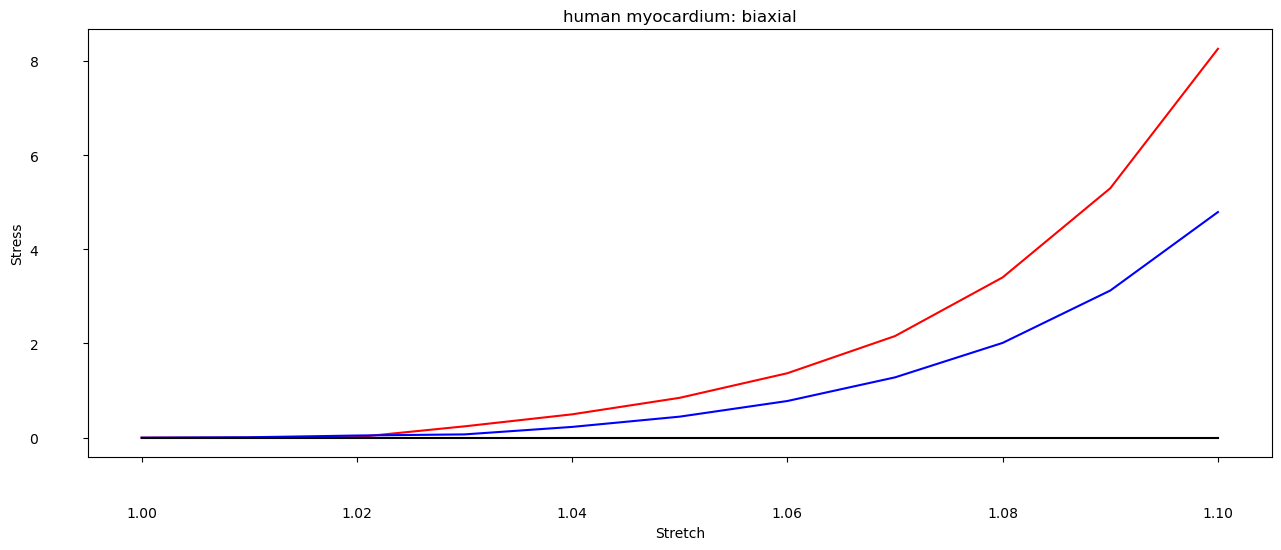

In [ ]:
# Load data for different testing modes
def getStressStrain(Region):
    if Region =='heart':
        i=0
        P_fs = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_fs = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_fn = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_fn = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5

        P_sf = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_sf = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_sn = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_sn = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5

        P_nf = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        gamma_nf = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_ns = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        gamma_ns = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5
        #biaxial test 1:1
        P_1010_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1010_f = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_1010_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1010_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5
        #biaxial test 1:075
        P_1007_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1007_f = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_1007_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1007_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5
        #biaxial test 075:1
        P_0710_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_0710_f = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_0710_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_0710_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5
        #biaxial test 1:05
        P_1005_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_1005_f = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_1005_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_1005_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

        i=i+5
        # #biaxial test 05:1
        P_0510_f = dfs.iloc[3:,i+1].dropna().astype(np.float64).values
        stretch_0510_f = dfs.iloc[3:,i].dropna().astype(np.float64).values

        P_0510_n = dfs.iloc[3:,i+3].dropna().astype(np.float64).values
        stretch_0510_n = dfs.iloc[3:,i+2].dropna().astype(np.float64).values

    return (P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
    P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
    P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
    P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
    P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
    P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n)

# Define different loading protocols
def traindata(modelFit_mode):
    if modelFit_mode == 'fs':
        model_given = model_fs
        input_train = gamma_fs
        output_train = P_fs
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == "fn":
        model_given = model_fn
        input_train = gamma_fn
        output_train = P_fn
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == "sf":
        model_given = model_sf
        input_train = gamma_sf
        output_train = P_sf
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == 'sn':
        model_given = model_sn
        input_train = gamma_sn
        output_train = P_sn
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == "nf":
        model_given = model_nf
        input_train = gamma_nf
        output_train = P_nf
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == "ns":
        model_given = model_ns
        input_train = gamma_ns
        output_train = P_ns
        sample_weights = np.array([1.0]*input_train.shape[0])

    if modelFit_mode == "biaxial_all":
        model_given = model_bi_all
        input_train = [[stretch_1010_f, stretch_1010_n],[stretch_0510_f, stretch_0510_n],[stretch_1005_f, stretch_1005_n],[stretch_0710_f, stretch_0710_n],[stretch_1007_f, stretch_1007_n]] #separate models for biaxial data so input and output need 2 arrays
        output_train = [[P_1010_f, P_1010_n],[P_0510_f, P_0510_n],[P_1005_f, P_1005_n],[P_0710_f, P_0710_n],[P_1007_f, P_1007_n]]

        sample_weights_1010_f = np.array([1.0] * stretch_1010_f.shape[0])
       # sample_weights_1010_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_1010_n = np.array([1.0] * stretch_1010_n.shape[0])
       # sample_weights_1010_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_2_f = np.array([1.0] * stretch_1007_f.shape[0])
        #sample_weights_2_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_2_n = np.array([1.0] * stretch_1007_n.shape[0])
        #sample_weights_2_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_3_f = np.array([1.0] * stretch_0710_f.shape[0])
        #sample_weights_3_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_3_n = np.array([1.0] * stretch_0710_n.shape[0])
        #sample_weights_3_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_4_f = np.array([1.0] * stretch_1005_f.shape[0])
        #sample_weights_4_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_4_n = np.array([1.0] * stretch_1005_n.shape[0])
        #sample_weights_4_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_5_f = np.array([1.0] * stretch_0510_f.shape[0])
        #sample_weights_5_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_5_n = np.array([1.0] * stretch_0510_n.shape[0])
        #sample_weights_5_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights = [[sample_weights_1010_f],[sample_weights_1010_n],[sample_weights_2_f],[sample_weights_2_n],[sample_weights_3_f],[sample_weights_3_n],[sample_weights_4_f],[sample_weights_4_n],[sample_weights_5_f],[sample_weights_5_n]]


    if modelFit_mode == "shear_all":
        model_given = model_sh_all
        input_train = [[gamma_fs], [gamma_fn],[gamma_sf],[gamma_sn],[gamma_nf],[gamma_ns]] #separate models for 6 shear data so input and output need 6 arrays
        output_train = [[P_fs], [P_fn],[P_sf],[P_sn],[P_nf],[P_ns]]
        # Weigh all stresses the same in the loss fn (normalize to 1)
        # can weight data points differently in the loss function, here we have weighted to by normalizig by the stress values
        sample_weights_fs = np.array([1.0] * gamma_fs.shape[0])
        #sample_weights_fs = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_fn = np.array([1.0] * gamma_fn.shape[0])
        #sample_weights_fn = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_sf = np.array([1.0] * gamma_sf.shape[0])
        #sample_weights_sf = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_sn = np.array([1.0] * gamma_sn.shape[0])
        #sample_weights_sn = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_nf = np.array([1.0] * gamma_nf.shape[0])
        #sample_weights_nf = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_ns = np.array([1.0] * gamma_ns.shape[0])
        #sample_weights_ns = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights = [[sample_weights_fs], [sample_weights_fn],[sample_weights_sf],[sample_weights_sn],[sample_weights_nf],[sample_weights_ns]]

    elif modelFit_mode == "biaxial_shear_all":  ##all shear tests and biaxial 1:1, 1:05
        model_given = model_sh_bi
        input_train = [[gamma_fs], [gamma_fn],[gamma_sf],[gamma_sn],[gamma_nf],[gamma_ns],
         [stretch_1010_f, stretch_1010_n],[stretch_0710_f, stretch_0710_n],[stretch_1007_f, stretch_1007_n],[stretch_0510_f, stretch_0510_n],[stretch_1005_f, stretch_1005_n]] #separate models for 6 shear data so input and output need 6 arrays
        output_train = [[P_fs], [P_fn],[P_sf],[P_sn],[P_nf], [P_ns], [P_1010_f, P_1010_n],[P_0710_f, P_0710_n],[P_1007_f, P_1007_n],[P_0510_f, P_0510_n],[P_1005_f, P_1005_n]]
        # Weigh all stresses the same in the loss fn (normalize to 1)
        sample_weights_fs = np.array([1.0] * gamma_fs.shape[0])
        #sample_weights_fs = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_fn = np.array([1.0] * gamma_fn.shape[0])
        #sample_weights_fn = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_sf = np.array([1.0] * gamma_sf.shape[0])
        #sample_weights_sf = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_sn = np.array([1.0] * gamma_sn.shape[0])
        #sample_weights_sn = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_nf = np.array([1.0] * gamma_nf.shape[0])
        #sample_weights_nf = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_ns = np.array([1.0] * gamma_ns.shape[0])
        #sample_weights_ns = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_1010_f = np.array([1.0] * stretch_1010_f.shape[0])
        #sample_weights_1010_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_1010_n = np.array([1.0] * stretch_1010_n.shape[0])
        #sample_weights_1010_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_2_f = np.array([1.0] * stretch_1007_f.shape[0])
        #sample_weights_2_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_2_n = np.array([1.0] * stretch_1007_n.shape[0])
        #sample_weights_2_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_3_f = np.array([1.0] * stretch_0710_f.shape[0])
        #sample_weights_3_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_3_n = np.array([1.0] * stretch_0710_n.shape[0])
        #sample_weights_3_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_4_f = np.array([1.0] * stretch_1005_f.shape[0])
        #sample_weights_4_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_4_n = np.array([1.0] * stretch_1005_n.shape[0])
        #sample_weights_4_n = np.random.uniform(0.001,1,gamma_fs.shape[0])

        sample_weights_5_f = np.array([1.0] * stretch_0510_f.shape[0])
        #sample_weights_5_f = np.random.uniform(0.001,1,gamma_fs.shape[0])
        sample_weights_5_n = np.array([1.0] * stretch_0510_n.shape[0])
        #sample_weights_5_n = np.random.uniform(0.001,1,gamma_fs.shape[0])


        sample_weights = [[sample_weights_fs], [sample_weights_fn],[sample_weights_sf],[sample_weights_sn],[sample_weights_nf],[sample_weights_ns],
         [sample_weights_1010_f],[sample_weights_1010_n],[sample_weights_2_f],[sample_weights_2_n],[sample_weights_3_f],[sample_weights_3_n],[sample_weights_4_f],[sample_weights_4_n],[sample_weights_5_f],[sample_weights_5_n]]

    return model_given, input_train, output_train, sample_weights

Region_test = 'heart'
(P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n) = getStressStrain(Region_test)

plt.figure(figsize=(1100/72,400/72))
plt.plot(stretch_1010_f, P_1010_f,color='red')
plt.plot(stretch_1010_n, P_1010_n,color='blue')
#plt.plot(stretch_1010_f, Stress_predict_bi[1,:],color='yellow')
#plt.plot(stretch_1010_n, Stress_predict_bi[2,:],color='black')

#plt.plot(gamma_fn,gamma_fn,color='yellow')
plt.plot(np.linspace(1., 1.1, 100), np.linspace(0,0,100),'k')
plt.xlabel('Stretch')
plt.ylabel('Stress')
plt.title('human myocardium: biaxial')

Text(0.5, 1.0, 'human myocardium: shear')

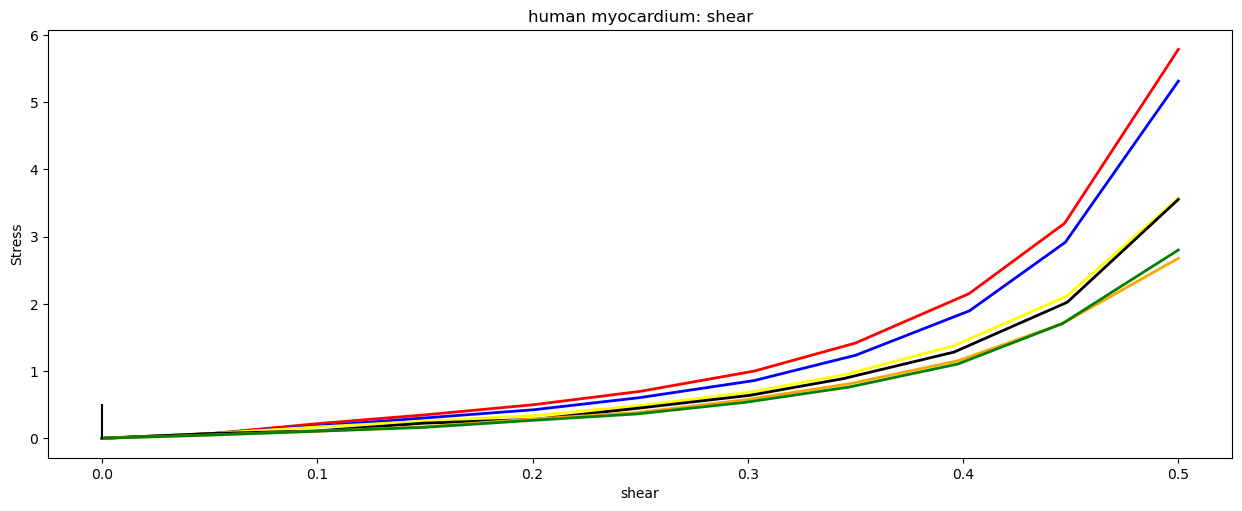

In [ ]:
# plotshear
plt.figure(figsize=(1100/72,400/72))
plt.plot(gamma_fs,P_fs, linewidth=2.0,color='red')
plt.plot(gamma_fn,P_fn, linewidth=2.0,color='blue')
plt.plot(gamma_sf,P_sf, linewidth=2.0,color='yellow')
plt.plot(gamma_sn,P_sn, linewidth=2.0,color='black')
plt.plot(gamma_nf,P_nf, linewidth=2.0,color='orange')
plt.plot(gamma_ns,P_ns, linewidth=2.0,color='green')
plt.plot(np.linspace(0, 0, 100), np.linspace(0.0,0.5,100),'k')

plt.xlabel('shear')
plt.ylabel('Stress')
plt.title('human myocardium: shear')

### L1 and L2 regularization with penalty weight



In [ ]:
def regularize(reg, pen):
    if reg == 'L2':
        return keras.regularizers.l2(pen)
    if reg == 'L1':
        return keras.regularizers.l1(pen)

## 2a. Strain Energy Model - Invariant-based - general HO model


$$
\begin{array}{l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{.02cm}}l@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.04cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}l}
    \psi(I_1,I_{4f},I_{4s},I_{4n},I_{8fs},I_{8fn},I_{8sn})
&=&  w_{2,2} & [ \, \exp (\,     w_{1,2} & [\, I_1 -3 \,]&)   - 1\,]
\\
&+& w_{2,12} & [ \, \exp (\,     w_{1,12} & [\, I_{4f} -1 \,]^2&) - 1\,]
\\
&+& w_{2,16} & [ \, \exp (\,     w_{1,16} & [\, I_{4s} -1 \,]^2&) - 1\,]
\\
&+& w_{2,20} & [ \, \exp (\,     w_{1,20} & [\, I_{4n} -1 \,]^2&) - 1\,]
\\
&+& w_{2,24} & [ \, \exp (\,     w_{1,24} & [\, I_{8fs} \,]^2&) - 1\,]
\\
&+& w_{2,28} & [ \, \exp (\,     w_{1,28} & [\, I_{8fn} \,]^2&) - 1\,]
\\
&+& w_{2,32} & [ \, \exp (\,     w_{1,32} & [\, I_{8sn} \,]^2&) - 1\,]
\end{array}
$$


First we define the activation functions and a single Invariant block:

In [ ]:
initializer_exp = tf.keras.initializers.RandomUniform(minval=0., maxval=0.1, seed=np.random.randint(0,10000)) # use random integer as seed
initializer_1 = 'glorot_normal'
initializer_2=keras.initializers.Zeros()
# Self defined activation functions for exp term
def activation_Exp(x):
    return 1.0*(tf.math.exp(x)-1.0)
# Self defined activation functions for ln term
def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

# Define network block
## kernel is weight
def SingleInvNet(I1_ref, idi, reg, pen, mode):

    # input: invariant
    if mode==1:
      I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation, correspont to the top ptahway in graph

      I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(2+idi)+'1')(I1_ref) # exp activation, 2nd line in graph

      I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(3+idi)+'1')(tf.math.square(I1_ref)) # no activation

      I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    elif mode==2:
      I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation, correspont to the top ptahway in graph
      I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(2+idi)+'1')(I1_ref) # exp activation, 2nd line in graph
      I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(3+idi)+'1')(tf.math.square(I1_ref)) # no activation
      I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    elif mode==0:
      I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation, correspont to the top ptahway in graph
      I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(2+idi)+'1')(I1_ref) # exp activation, 2nd line in graph
      I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_2,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(3+idi)+'1')(tf.math.square(I1_ref)) # no activation
      I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=tf.keras.constraints.min_max_norm(min_value=0.0, max_value=0.0, rate=1.0, axis=0),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # exp activation

    # I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                           use_bias=False, activation=activation_ln,name='w'+str(3+idi)+'1')(I1_ref) # ln activation

    # input: invariant^2

    # I_1_w61 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                           use_bias=False, activation=activation_ln,name='w'+str(6+idi)+'1')(tf.math.square(I1_ref)) # ln activation

    collect = [I_1_w11, I_1_w21,  I_1_w31, I_1_w41]
    collect_out = tf.keras.layers.concatenate(collect, axis=1)

    return collect_out

Then we define the strain energy keras submodel as:

In [ ]:
def StrainEnergyCANN_invariant(reg, pen):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')
    I4f_in = tf.keras.Input(shape=(1,), name='I4f')
    I4s_in = tf.keras.Input(shape=(1,), name='I4s')
    I4n_in = tf.keras.Input(shape=(1,), name='I4n')
    I8fs_in = tf.keras.Input(shape=(1,), name='I8fs')
    I8fn_in = tf.keras.Input(shape=(1,), name='I8fn')
    I8sn_in = tf.keras.Input(shape=(1,), name='I8sn')

    # Put invariants in the reference configuration (substrct 3)
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)
    I2_ref = keras.layers.Lambda(lambda x: (x-3.0))(I2_in)
    I4f_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4f_in)
    I4s_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4s_in)
    I4n_ref = keras.layers.Lambda(lambda x: (x-1.0))(I4n_in)
    I8fs_ref = keras.layers.Lambda(lambda x: (x))(I8fs_in)
    I8fn_ref = keras.layers.Lambda(lambda x: (x))(I8fn_in)
    I8sn_ref = keras.layers.Lambda(lambda x: (x))(I8sn_in)

    I1_out = SingleInvNet(I1_ref, 0, reg, pen,1)
    terms = I1_out.get_shape().as_list()[1] # 4 terms per invariant
    I2_out = SingleInvNet(I2_ref, terms, reg, pen,0)
    I4f_out = SingleInvNet(I4f_ref, 2*terms, reg, pen,2)
    I4s_out = SingleInvNet(I4s_ref, 3*terms, reg, pen,2)
    I4n_out = SingleInvNet(I4n_ref, 4*terms, reg, pen,2)
    I8fs_out = SingleInvNet(I8fs_ref, 5*terms, reg, pen,2)
    I8fn_out = SingleInvNet(I8fn_ref, 6*terms, reg, pen,2)
    I8sn_out = SingleInvNet(I8sn_ref, 7*terms, reg, pen,2)

    ALL_I_out = [I1_out,I2_out,I4f_out,I4s_out,I4n_out,I8fs_out,I8fn_out,I8sn_out]
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out,axis=1)

    # second layer
    ## get 2nd col of weights
    W_ANN = keras.layers.Dense(1,kernel_initializer='glorot_normal',kernel_constraint=keras.constraints.NonNeg(),
                               kernel_regularizer=regularize(reg, pen),
                           use_bias=False, activation=None,name='wx2')(ALL_I_out)
    Psi_model = keras.models.Model(inputs=[I1_in, I2_in, I4f_in, I4s_in, I4n_in, I8fs_in, I8fn_in, I8sn_in], outputs=[W_ANN], name='Psi')

    return Psi_model, terms*8  # 32 terms




### 3. Stress Models



####  Biaxial tension

For the case of biaxial tension, we stretch the specimen in two directions (fibre and cross-fibre (normal) directions,
$F_{ff} = \lambda_1 $ and $F_{nn} = \lambda_2 $
For an isotropic, perfectly incompressible material with
$I_3 = \lambda_1^2  \lambda_2^2  \lambda_3^2 = 1$,
the stretches orthogonal to the loading direction are identical and equal to the square root of the stretch,
$F_{22} = \lambda_2 = \lambda^{-1/2}$ and
$F_{33} = \lambda_3 = \lambda^{-1/2}$.

For the exact terms see https://royalsocietypublishing.org/doi/10.1098/rsta.2009.0091


In [ ]:
def uCANN_h1(x,kf):
    # calculate first layer output f,df,ddf for activation function kf
    zero = tf.constant(0.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    three = tf.constant(3.0,dtype='float32')
    if kf == 1:
        f = x
        df = one
        ddf = zero
    elif kf == 2:
        f = (x)**2
        df = two*x
        ddf = two
    return f,df,ddf

def uCANN_h2(x,w,kf):
    # calculate second layer output f,df,ddf for activation function kf
    zero = tf.constant(0.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    three = tf.constant(3.0,dtype='float32')
    if kf == 1:
        f = w * x
        df = w * one
        ddf = w * zero
    elif kf == 2:
        f = tf.math.exp(w*x)-1
        df = w*tf.math.exp(w*x)
        ddf = w**2 * tf.math.exp(w*x)
    return f,df,ddf


def Stress_cal_f(inputs):
    (dWI1,dWI2,dWI4_f,stretch_f,stretch_n) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    three = tf.constant(3.0,dtype='float32')

    #according to Holzapfel 2009
    stretch_s = one/(stretch_f*stretch_n)
    stress_f = two * (dWI1 * (stretch_f*stretch_f - stretch_s*stretch_s)  + dWI2 * stretch_n*stretch_n*(stretch_f*stretch_f - stretch_s*stretch_s) + dWI4_f * stretch_f*stretch_f )
    #stress_f = two * ( dpsidi2 * stretch_n*stretch_n*(stretch_f*stretch_f - stretch_s*stretch_s) )*thousend
    return stress_f

def Stress_cal_n(inputs):
    (dWI1,dWI2,dWI4_n,stretch_f,stretch_n) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')

    #according to Holzapfel 2009
    stretch_s = one/(stretch_f*stretch_n)
    stress_n = two * (dWI1 * (stretch_n*stretch_n - stretch_s*stretch_s)  + dWI2 * stretch_f*stretch_f*(stretch_n*stretch_n - stretch_s*stretch_s) +  dWI4_n * stretch_n*stretch_n)

    return stress_n

####  Shear

For the case of simple shear, we shear the specimen in 6 direction.

For the exact terms see https://royalsocietypublishing.org/doi/10.1098/rsta.2009.0091

In [ ]:

# Simple shear stress
def stress_cal_ss_ortho(inputs):
    (dPsidI1, dPsidI2, dPsidI4,dPsidI8, gamma) = inputs
    two = tf.constant(2.0,dtype='float32')
    stress = two*gamma * (dPsidI1  + dPsidI2 + dPsidI4) + dPsidI8
    return stress


Finally, we can define seperate stress models for tension/compression, shear and a combination of all loading states.

In [ ]:
# Gradient function
## automatic gradients
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]

def modelArchitecture(Psi_model):
    # Stretch and Gamma as input
    #print(modelFit_mode)


    Gamma_fs = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_fs')

    Gamma_fn = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_fn')

    Gamma_sf = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_sf')

    Gamma_sn = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_sn')

    Gamma_nf = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_nf')

    Gamma_ns = keras.layers.Input(shape = (1,),
                                  name = 'Gamma_ns')

    Stretch_f_1 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_1')
    Stretch_n_1 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_1')

    Stretch_f_2 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_2')
    Stretch_n_2 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_2')

    Stretch_f_3 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_3')
    Stretch_n_3 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_3')

    Stretch_f_4 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_4')
    Stretch_n_4 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_4')

    Stretch_f_5 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_f_5')
    Stretch_n_5 = keras.layers.Input(shape = (1,),
                                  name = 'Stretch_n_5')

    #models for all possible shear modes
    zero = tf.constant(0.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    #(fs)
    I1_fs = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fs)
    I2_fs = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fs)
    I4f_fs = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_fs)
    I4s_fs = keras.layers.Lambda(lambda x:  x**0)(Gamma_fs)
    I4n_fs = keras.layers.Lambda(lambda x: x**0)(Gamma_fs)
    I8fs_fs = keras.layers.Lambda(lambda x: x**1)(Gamma_fs)
    I8fn_fs = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fs)
    I8sn_fs = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fs)
    Psi_fs = Psi_model([I1_fs,I2_fs,I4f_fs,I4s_fs,I4n_fs,I8fs_fs,I8fn_fs,I8sn_fs])
    dWI1_fs  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I1_fs])
    dWdI2_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I2_fs])
    dWdI4f_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I4f_fs])
    dWdI8fs_fs = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fs, I8fs_fs])
    print(dWdI8fs_fs)
    Stress_fs = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_fs')([dWI1_fs,dWdI2_fs,dWdI4f_fs,dWdI8fs_fs,Gamma_fs])
    #(fn)
    I1_fn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fn)
    I2_fn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_fn)
    I4f_fn = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_fn)
    I4s_fn = keras.layers.Lambda(lambda x:  x**0)(Gamma_fn)
    I4n_fn = keras.layers.Lambda(lambda x: x**0)(Gamma_fn)
    I8fn_fn = keras.layers.Lambda(lambda x: x**1)(Gamma_fn)
    I8fs_fn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fn)
    I8sn_fn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_fn)
    Psi_fn = Psi_model([I1_fn, I2_fn,I4f_fn,I4s_fn,I4n_fn,I8fs_fn,I8fn_fn,I8sn_fn])
    dWI1_fn  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I1_fn])
    dWdI2_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I2_fn])
    dWdI4f_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I4f_fn])
    dWdI8fn_fn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_fn, I8fn_fn])
    Stress_fn = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_fn')([dWI1_fn,dWdI2_fn,dWdI4f_fn,dWdI8fn_fn, Gamma_fn])
    #(sf)
    I1_sf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sf)
    I2_sf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sf)
    I4s_sf = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_sf)
    I4f_sf = keras.layers.Lambda(lambda x:  x**0)(Gamma_sf)
    I4n_sf = keras.layers.Lambda(lambda x: x**0)(Gamma_sf)
    I8fs_sf = keras.layers.Lambda(lambda x: x**1)(Gamma_sf)
    I8fn_sf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sf)
    I8sn_sf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sf)
    Psi_sf = Psi_model([I1_sf, I2_sf,I4f_sf,I4s_sf,I4n_sf,I8fs_sf,I8fn_sf,I8sn_sf])
    dWI1_sf  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I1_sf])
    dWdI2_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I2_sf])
    dWdI4s_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I4s_sf])
    dWdI8fs_sf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sf, I8fs_sf])
    Stress_sf = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_sf')([dWI1_sf,dWdI2_sf,dWdI4s_sf,dWdI8fs_sf,Gamma_sf])
    #(sn)
    I1_sn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sn)
    I2_sn = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_sn)
    I4s_sn = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_sn)
    I4f_sn = keras.layers.Lambda(lambda x:  x**0)(Gamma_sn)
    I4n_sn = keras.layers.Lambda(lambda x: x**0)(Gamma_sn)
    I8sn_sn = keras.layers.Lambda(lambda x: x**1)(Gamma_sn)
    I8fs_sn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sn)
    I8fn_sn = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_sn)
    Psi_sn = Psi_model([I1_sn, I2_sn,I4f_sn,I4s_sn,I4n_sn,I8fs_sn,I8fn_sn,I8sn_sn])
    dWI1_sn  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I1_sn])
    dWdI2_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I2_sn])
    dWdI4s_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I4f_sn])
    dWdI8sn_sn = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_sn, I8sn_sn])
    Stress_sn = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_sn')([dWI1_sn,dWdI2_sn,dWdI4s_sn,dWdI8sn_sn,Gamma_sn])
    #(nf)
    I1_nf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_nf)
    I2_nf = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_nf)
    I4n_nf = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_nf)
    I4f_nf = keras.layers.Lambda(lambda x:  x**0)(Gamma_nf)
    I4s_nf = keras.layers.Lambda(lambda x: x**0)(Gamma_nf)
    I8fn_nf = keras.layers.Lambda(lambda x: x**1)(Gamma_nf)
    I8fs_nf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_nf)
    I8sn_nf = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_nf)
    Psi_nf = Psi_model([I1_nf, I2_nf,I4f_nf,I4s_nf,I4n_nf,I8fs_nf,I8fn_nf,I8sn_nf])
    dWI1_nf  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I1_nf])
    dWdI2_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I2_nf])
    dWdI4n_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I4n_nf])
    dWdI8fn_nf = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_nf, I8fn_nf])
    Stress_nf = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_nf')([dWI1_nf,dWdI2_nf,dWdI4n_nf,dWdI8fn_nf,Gamma_nf])
    #(ns)
    I1_ns = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_ns)
    I2_ns = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma_ns)
    I4n_ns = keras.layers.Lambda(lambda x: 1.0 + x**2)(Gamma_ns)
    I4f_ns = keras.layers.Lambda(lambda x:  x**0)(Gamma_ns)
    I4s_ns = keras.layers.Lambda(lambda x: x**0)(Gamma_ns)
    I8sn_ns = keras.layers.Lambda(lambda x: x**1)(Gamma_ns)
    I8fs_ns = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_ns)
    I8fn_ns = keras.layers.Lambda(lambda x: x**0-1.0)(Gamma_ns)
    Psi_ns = Psi_model([I1_ns, I2_ns,I4f_ns,I4s_ns,I4n_ns,I8fs_ns,I8fn_ns,I8sn_ns])
    dWI1_ns  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I1_ns])
    dWdI2_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I2_ns])
    dWdI4n_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I4n_ns])
    dWdI8sn_ns = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ns, I8sn_ns])
    Stress_ns = keras.layers.Lambda(function = stress_cal_ss_ortho,
                                name = 'Stress_ns')([dWI1_ns,dWdI2_ns,dWdI4n_ns,dWdI8sn_ns,Gamma_ns])
    #models
    model_fs = keras.models.Model(inputs=Gamma_fs, outputs= Stress_fs)
    model_fn = keras.models.Model(inputs=Gamma_fn, outputs= Stress_fn)
    model_sf = keras.models.Model(inputs=Gamma_sf, outputs= Stress_sf)
    model_sn = keras.models.Model(inputs=Gamma_sn, outputs= Stress_sn)
    model_nf = keras.models.Model(inputs=Gamma_nf, outputs= Stress_nf)
    model_ns = keras.models.Model(inputs=Gamma_ns, outputs= Stress_ns)


   # biaxial
   # first biaxial model
    Stretch_f=Stretch_f_1
    Stretch_n=Stretch_n_1
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_f)
    I4s_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_s)
    I4n_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_n)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f1')([dWI1_bi,dWdI2_bi,dWdI4f_bi,Stretch_f,Stretch_n])
    Stress_n = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n1')([dWI1_bi,dWdI2_bi,dWdI4n_bi,Stretch_f,Stretch_n])
    model_bi = keras.models.Model(inputs=[Stretch_f,Stretch_n], outputs=[Stress_f,Stress_n])

# second biaxial model
    Stretch_f=Stretch_f_2
    Stretch_n=Stretch_n_2
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_f)
    I4s_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_s)
    I4n_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_n)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f2')([dWI1_bi,dWdI2_bi,dWdI4f_bi,Stretch_f,Stretch_n])
    Stress_n = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n2')([dWI1_bi,dWdI2_bi,dWdI4n_bi,Stretch_f,Stretch_n])

    model_bi_2 = keras.models.Model(inputs=[Stretch_f,Stretch_n], outputs=[Stress_f,Stress_n])


    # 3rd biaxial model
    Stretch_f=Stretch_f_3
    Stretch_n=Stretch_n_3
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_f)
    I4s_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_s)
    I4n_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_n)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f_3')([dWI1_bi,dWdI2_bi,dWdI4f_bi,Stretch_f,Stretch_n])
    Stress_n = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n_3')([dWI1_bi,dWdI2_bi,dWdI4n_bi,Stretch_f,Stretch_n])
    model_bi_3 = keras.models.Model(inputs=[Stretch_f,Stretch_n], outputs=[Stress_f,Stress_n])

    # 4th biaxial model
    Stretch_f=Stretch_f_4
    Stretch_n=Stretch_n_4
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_f)
    I4s_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_s)
    I4n_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_n)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f_4')([dWI1_bi,dWdI2_bi,dWdI4f_bi,Stretch_f,Stretch_n])
    Stress_n = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n_4')([dWI1_bi,dWdI2_bi,dWdI4n_bi,Stretch_f,Stretch_n])
    model_bi_4 = keras.models.Model(inputs=[Stretch_f,Stretch_n], outputs=[Stress_f,Stress_n])

    # 5th biaxial model
    Stretch_f=Stretch_f_5
    Stretch_n=Stretch_n_5
    Stretch_s = 1./(Stretch_f*Stretch_n)
    I1_bi = keras.layers.Lambda(lambda x: x[0]**2 +x[1]**2 + (1./(x[0]*x[1])**2))([Stretch_f,Stretch_n])
    I2_bi = keras.layers.Lambda(lambda x: (x[0]**2)*(x[1]**2) + 1/x[0]**2 + 1/x[1]**2)([Stretch_f,Stretch_n])
    I4f_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_f)
    I4s_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_s)
    I4n_bi = keras.layers.Lambda(lambda x: x**2)(Stretch_n)
    I8fs_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8fn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    I8sn_bi = keras.layers.Lambda(lambda x: x**0-1.0)(Stretch_f)
    Psi_bi = Psi_model([I1_bi, I2_bi, I4f_bi,I4s_bi,I4n_bi, I8fs_bi, I8fn_bi,I8sn_bi])
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWdI2_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I2_bi])
    dWdI4f_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4f_bi])
    dWdI4n_bi = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I4n_bi])
    Stress_f = keras.layers.Lambda(function = Stress_cal_f,
                                name = 'Stress_f_5')([dWI1_bi,dWdI2_bi,dWdI4f_bi,Stretch_f,Stretch_n])
    Stress_n = keras.layers.Lambda(function = Stress_cal_n,
                                name = 'Stress_n_5')([dWI1_bi,dWdI2_bi,dWdI4n_bi,Stretch_f,Stretch_n])
    model_bi_5 = keras.models.Model(inputs=[Stretch_f,Stretch_n], outputs=[Stress_f,Stress_n])


    # combined shear model
    input_sh=[model_fs.inputs, model_fn.inputs,model_sf.inputs,model_sn.inputs,model_nf.inputs,model_ns.inputs]
    output_sh=[model_fs.outputs,model_fn.outputs,model_sf.outputs,model_sn.outputs,model_nf.outputs,model_ns.outputs]
    model_sh_all = keras.models.Model(inputs=input_sh, outputs=output_sh)

    # combined biaxial model
    input_bi = [model_bi.inputs,model_bi_2.inputs,model_bi_3.inputs,model_bi_4.inputs,model_bi_5.inputs]
    output_bi = [model_bi.outputs,model_bi_2.outputs,model_bi_3.outputs,model_bi_4.outputs,model_bi_5.outputs]
    model_bi_all = keras.models.Model(inputs=input_bi,outputs=output_bi)


    # combined shear and biaxial
    input_sh_bi = [model_fs.inputs, model_fn.inputs,model_sf.inputs,model_sn.inputs,model_nf.inputs,model_ns.inputs,model_bi.inputs,model_bi_2.inputs,model_bi_3.inputs,model_bi_4.inputs,model_bi_5.inputs]
    output_sh_bi = [model_fs.outputs,model_fn.outputs,model_sf.outputs,model_sn.outputs,model_nf.outputs,model_ns.outputs, model_bi.outputs,model_bi_2.outputs,model_bi_3.outputs,model_bi_4.outputs,model_bi_5.outputs]
    model_sh_bi = keras.models.Model(inputs=input_sh_bi,outputs=output_sh_bi)


    return  model_fs, model_fn, model_sf,model_sn,model_nf,model_ns, model_bi,model_bi_2,model_bi_3,model_bi_4,model_bi_5, model_sh_all, model_bi_all, model_sh_bi, Psi_model


### 4. Compile model

The compiler definition comprises the loss function definition (here a mean squared error metric), the optimizer (here an Adam optimizer) and the evaluation metric (also mean squared error).

Moreover, we define model callbacks and the keras fit function. The latter obtains the information about which model we want to fit with which data.

In [ ]:
# Optimization utilities
def Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint, sample_weights):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  =[keras.metrics.MeanSquaredError()]
    opti1    = tf.optimizers.Adam(learning_rate=0.001)

    model_given.compile(loss=mse_loss,
                  optimizer=opti1,
                  metrics=metrics)

    # if training loss starts to increase, stop training after 3000 additional epochs = "patience"
    ## early stopping if loss increasing innstead of decreasing

    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.001, patience=200, restore_best_weights=True)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True, # save only the best weights across all epochs
    )

## model.fit - input/output pairs of data to train on
## sample_weights is how much each exampe is weighted in the loss fct
    history = model_given.fit(input_train,
                        output_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.0,
                        callbacks=[es_callback, modelckpt_callback], # save best weights if stop early or go through all epochs
                        shuffle = True,
                        verbose = 0, # verbose = 2 will print loss each epoch
                        sample_weight = sample_weights)
    return model_given, history


### 5. Plot functions

Here we define some plot functions to be used to plot the results later on

In [ ]:
def plotLoss(axe, history):
    axe.plot(history)
    axe.set_yscale('log')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [ ]:
# plot the contribution of each term to the model stress prediction
# shear stress
def color_map(ax, stretch, model, model_weights, Psi_model, cmaplist, terms, model_type):
    predictions = np.zeros([stretch.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights

    for i in range(terms):
        if model_type == 'Stretch':
            model_plot = np.zeros_like(model_weights)  # wx1 all set to zero
            model_plot[i] = model_weights[i]  # wx1[i] set to trained value
        else:  # for architectures with multiple layers (VL, invariant)
            model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
            model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

        Psi_model.set_weights(model_plot)
        lower = np.sum(predictions, axis=1)
        upper = lower + model.predict(stretch, verbose=0)[:].flatten()
        predictions[:, i] = model.predict(stretch, verbose=0)[:].flatten()
        ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
        ## plot each term's contribution

        # if i == 0:  # one or two term models, get the correct color
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[0],
        #                      label=i + 1)
        # else:
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[7],
        #                      label=i + 1)
        ax.plot(stretch, upper, lw=0.4, zorder=34, color='k')

# biaxial stress
def color_map_bi(ax, lamx, lamy,lamplot, model, model_weights, Psi_model, cmaplist, terms, label):
    predictions = np.zeros([lamx.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights
    for i in range(terms):
      #invarant based model
      model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
      model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

      Psi_model.set_weights(model_plot)
      lower = np.sum(predictions, axis=1)
      if label == 'x':
            upper = lower +  model.predict([lamx, lamy],verbose=0)[0][:].flatten()
            predictions[:,i] = model.predict([lamx, lamy],verbose=0)[0][:].flatten()
      else:
            upper = lower +  model.predict([lamx, lamy],verbose=0)[1][:].flatten()
            predictions[:,i] = model.predict([lamx, lamy],verbose=0)[1][:].flatten()

      ax.fill_between(lamplot[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
      ax.plot(lamplot, upper, lw=0.4, zorder=34, color='k')



In [ ]:
plt.rcParams['xtick.major.pad'] = 32 # set plotting parameters
plt.rcParams['ytick.major.pad'] = 32

# plot tension, compression, and shear brain data with color maps

# def plotMapCom(ax, Psi_model, model_weights, model_UT, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type):
#     if model_type == 'Invariant':
#         numTerms = 12
#     elif model_type == 'Stretch':
#         numTerms = 20  # change if change range
#     cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
#     cmaplist = [cmap(i) for i in range(cmap.N)]
#     ax.set_xticks([1, 0.98, 0.96, 0.94, 0.92, 0.9])
#     ax.set_xlim(1., 0.5)
#     if Region == 'heart':
#         ax.set_yticks([0, -0.22, -0.44, -0.66, -0.88, -1.1])
#         ax.set_ylim(0, 5.)

    # color_map(ax, lam_ut, model_UT, model_weights, Psi_model, cmaplist, terms, model_type)
    # ax.scatter(lam_ut, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    # plt.tight_layout(pad=2)
    # plt.savefig(path2saveResults + '/Compression_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    # plt.close();


def plotMapShear(ax, Psi_model, model_weights, model_SS, terms, gamma_SS, P_SS, Region, path2saveResults, modelFit_mode, model_type,label):

    if model_type == 'Invariant':
        numTerms = 32
    elif model_type == 'Stretch':
        numTerms = 32 # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([])
    ax.set_xlim(0.0, 0.5)
    if label == 'fs':
      y_max=5.80
    elif label == 'fn':
      y_max=5.35
    elif label == 'sf':
      y_max=3.60
    elif label == 'sn':
      y_max=3.55
    elif label == 'nf':
      y_max=2.70
    elif label == 'ns':
      y_max=2.80
    ax.set_yticks([])
    ax.set_ylim(0, y_max)

    color_map(ax, gamma_SS, model_SS, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(gamma_SS, P_SS, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    #plt.scatter(gamma_SS, P_SS,color='red')
    #ax.legend(loc='upper left', fancybox=True, framealpha=0., fontsize=14, ncol=2)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Shear_' +  '_'+ label +'_Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.show()
    #plt.close();

    # plot biaxial tension
def plotMapBi(ax, Psi_model, model_weights, model_bi, terms, lamx, lamy,lamplot, P_ut, Region, path2saveResults, modelFit_mode, model_type, label1,label2):
    if model_type == 'Invariant':
        numTerms = 32
    elif model_type == 'Stretch':
        numTerms = 32  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    # this way, we can use 1 or 2 term models and have the colors be the same for those terms
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([1.,1.04, 1.06, 1.08, 1.1])
    ax.set_xlim(1.,1.1)
    if label2 == '1010x':
      x_max=1.1
      x_min=1.0
      y_max=8.3
    elif label2 == '1010y':
      x_max=1.1
      x_min=1.0
      y_max=4.8
    elif label2 == '1007x':
      x_max=1.1
      x_min=1.0
      y_max=5.9
    elif label2 == '1007y':
      x_max=1.075
      x_min=1.0
      y_max=2.8
    elif label2 == '0710x':
      x_max=1.075
      x_min=1.0
      y_max=3.7
    elif label2 == '0710y':
      x_max=1.1
      x_min=1.0
      y_max=2.80
    elif label2 == '1005x':
      x_max=1.1
      x_min=1.0
      y_max=4.8
    elif label2 == '1005y':
      x_max=1.05
      x_min=1.0
      y_max=1.8
    elif label2 == '0510x':
      x_max=1.05
      x_min=1.0
      y_max=2.5
    elif label2 == '0510y':
      x_max=1.1
      x_min=1.0
      y_max=3.1

    ax.set_xticks([])
    ax.set_xlim(x_min, x_max)
    ax.set_yticks([])
    ax.set_ylim(0.0, y_max)

    color_map_bi(ax, lamx, lamy,lamplot, model_bi, model_weights, Psi_model, cmaplist, terms, label1)
    ax.scatter(lamplot, P_ut,color='red')
    ax.scatter(lamplot, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Biaxial_' +  '_'+ label2 +'_Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.show()
    #plt.close();


### 6. Model Training

Parameters and definitions for the model training. Try changing the number of epochs and toggling between the invariant and principal-stretch-based model. Make sure to rename the model_type variable for each test.

In [ ]:
train = False
epochs = 30000 # try ~20,000 epochs for a good fit
batch_size = 32

### Choose regularization type & penalty amount
# Option: 'L1', 'L2'; for VL used L2=0.001, for Stretch no reg was used
reg = 'L1'
pen = 0.0 # Use 0 for no regularization

folder_name = 'wg32_shear05_orthotrop_HO_general_L1_wg1_'+str(epochs)+'_'+ str(batch_size)+'_'+str(pen) # name the folder for your results

### Choose which model type to build CANN architecture with
# Options: 'Stretch', 'Invariant'
# 'Stretch' is principal-stretch-based and contains stretches raised to fixed powers (range & number of terms can be adjusted)
# 'Invariant' is invariant-based and contains I2, I2, I1^2, I2^2 and all with exp() and ln() activations
model_type = 'Invariant'

### Choose which loading modes to train with
# shear_all  all 6 shear tests simultaneously
# biaxial_all  all biaxial tests simultaneously
# biaxial_shear_all all tests simulataneously
modelFit_mode_all = ['biaxial_shear_all']


### Choose which types of artificial meat to train with
# Options: 'CC', 'CX', 'BG', 'CR'
Region_all = ['heart']
################################################


def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)


filename = 'HeartCANN'
path2saveResults_0 = path + 'results_shear05/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)
Model_summary = path2saveResults_0 + '/Model_summary.txt'



Comp 1 / 1
Region:  heart | Fitting Mode:  biaxial_shear_all
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lambda_159/zeros_like:0', description="created by layer 'lambda_159'")
weight_matrix
[[-0.00000000e+00 -0.00000000e+00]
 [ 5.45766163e+00  8.75851735e-02]
 [ 0.00000000e+00  5.73747717e-02]
 [ 0.00000000e+00  5.22481382e-01]
 [-0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  7.01209232e-02]
 [ 0.00000000e+00  1.22824311e-01]
 [ 0.00000000e+00  5.00532659e-03]
 [-0.00000000e+00  2.85030663e-01]
 [-0.00000000e+00  1.88400950e-02]
 [-0.00000000e+00  1.50398478e-01]
 [ 2.37010078e+01  7.08407909e-02]
 [-0.00000000e+00  1.91126987e-01]
 [-0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  5.18887639e-02]
 [ 2.00677757e+01  3.55011113e-02]
 [-0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  6.76059127e-02]
 [ 1.69766998e+01  6.05346076e-02]
 [-0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  4.63397622e-01

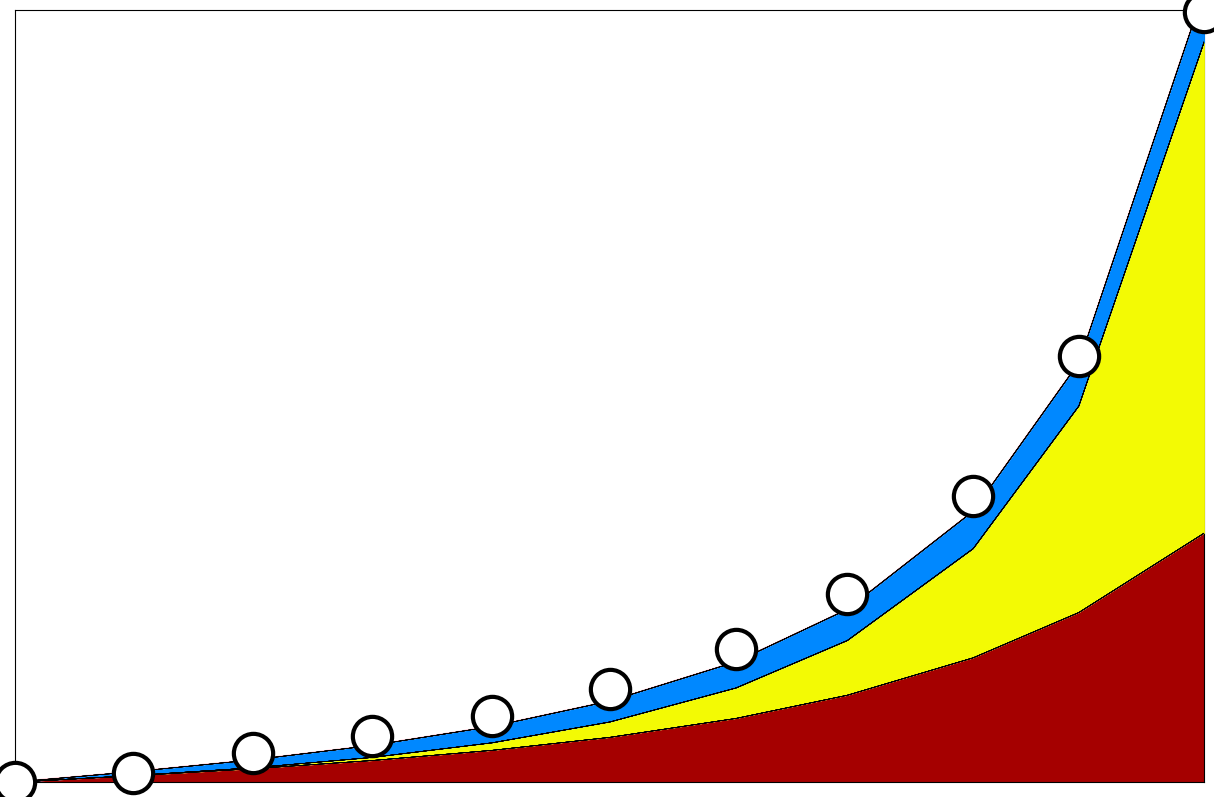

R2 fs =  0.9970987706100722


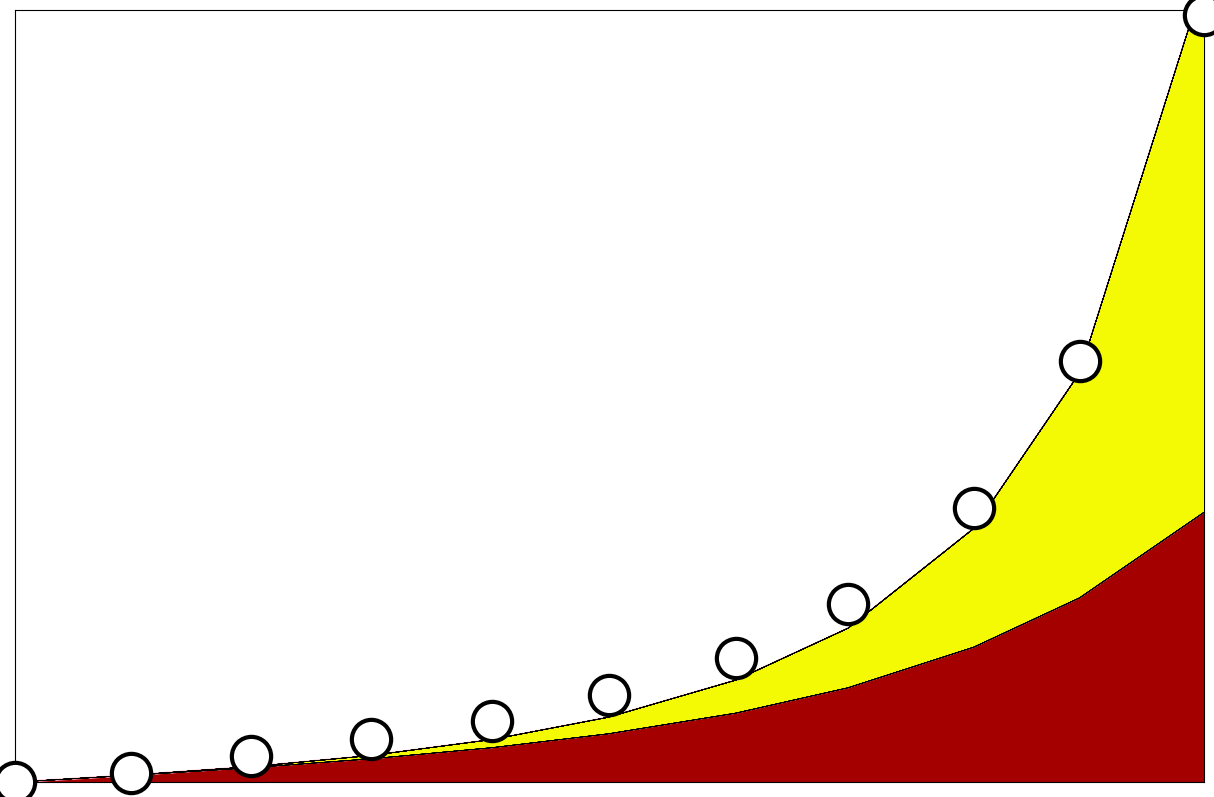

R2 fn =  0.9922272487308478


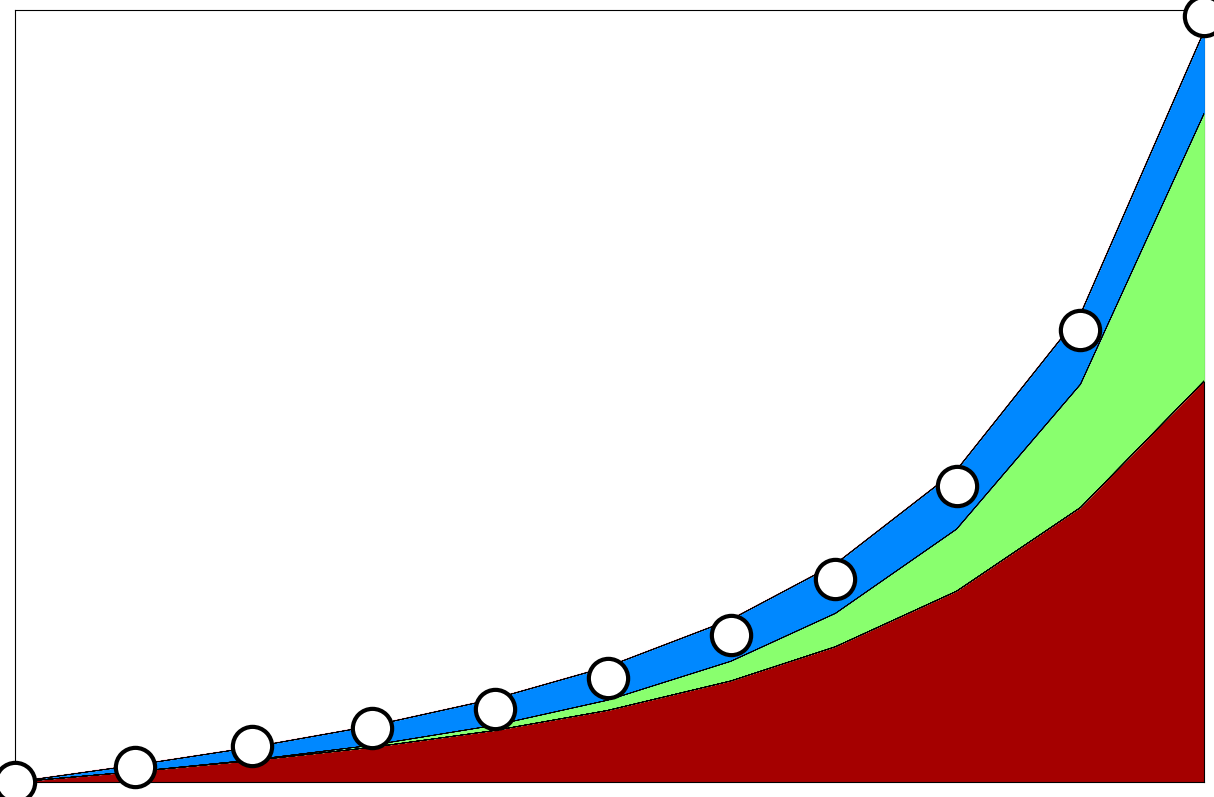

R2 sf =  0.9973760107897884


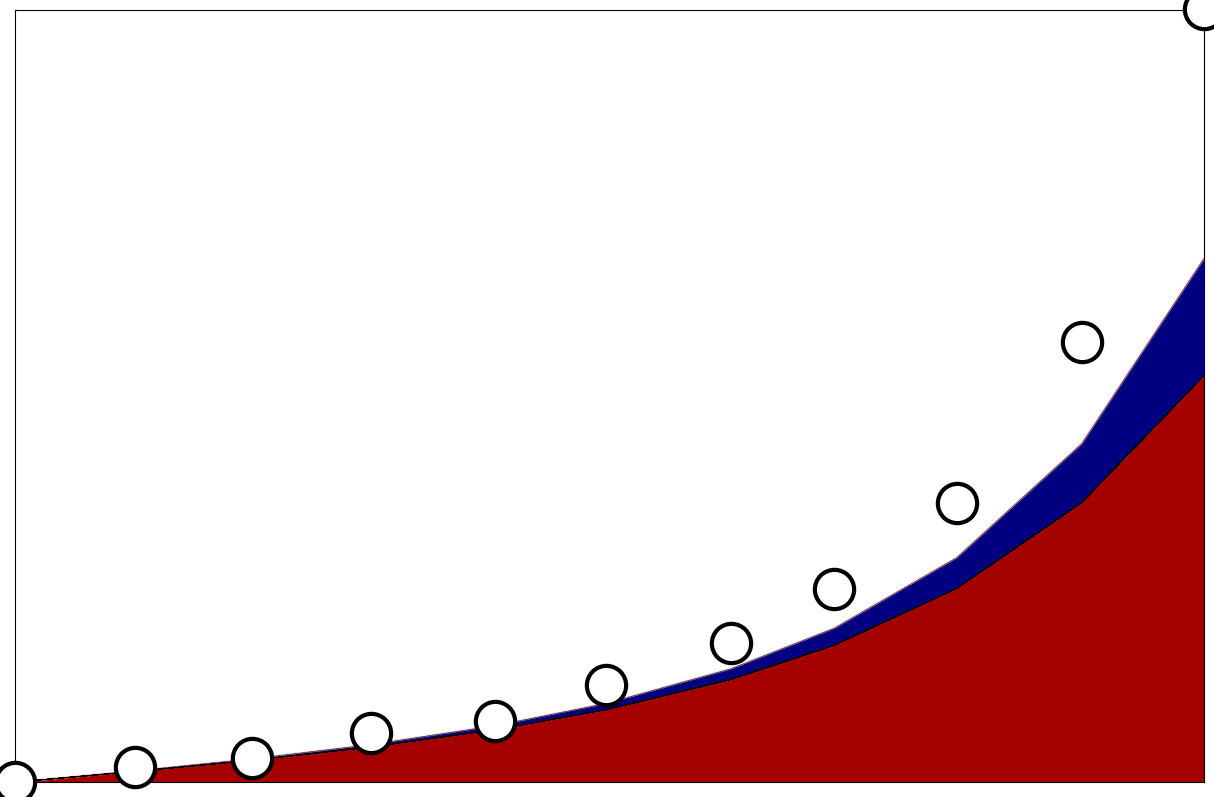

R2 sn =  0.8587792257713552


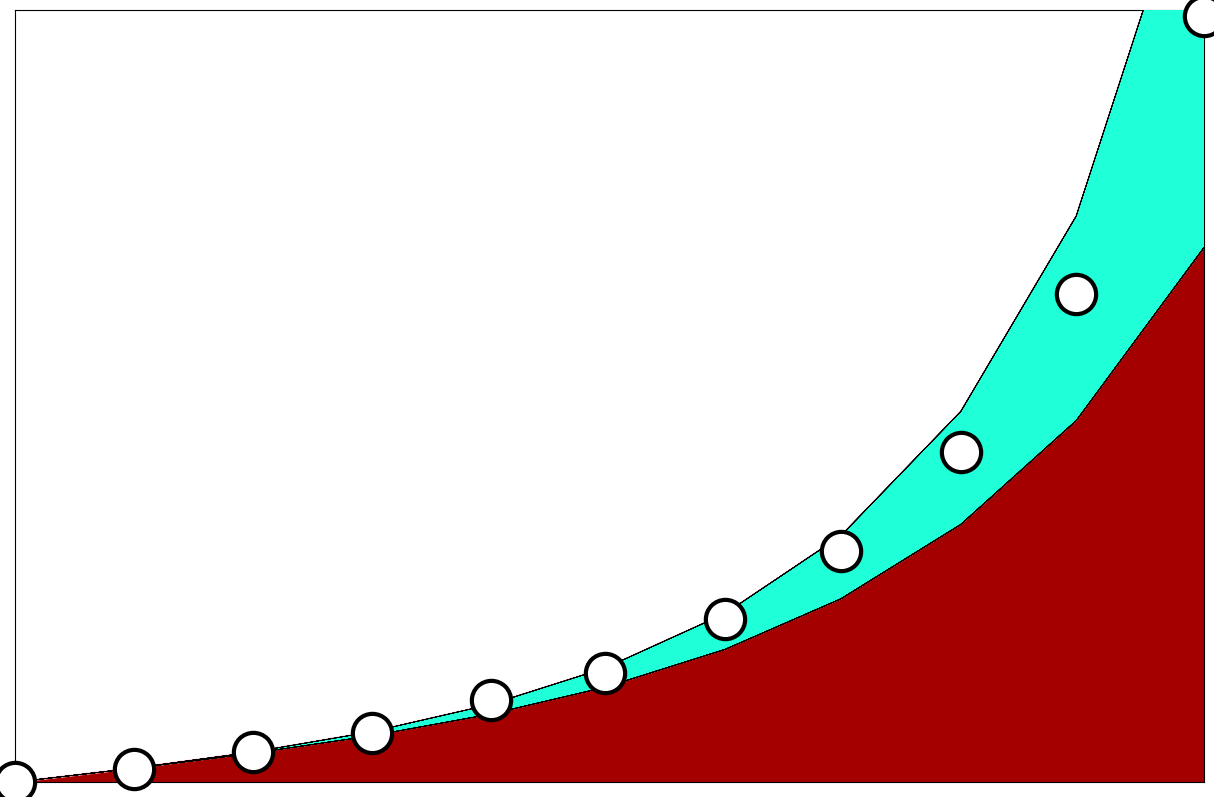

R2 nf =  0.9196149192556181


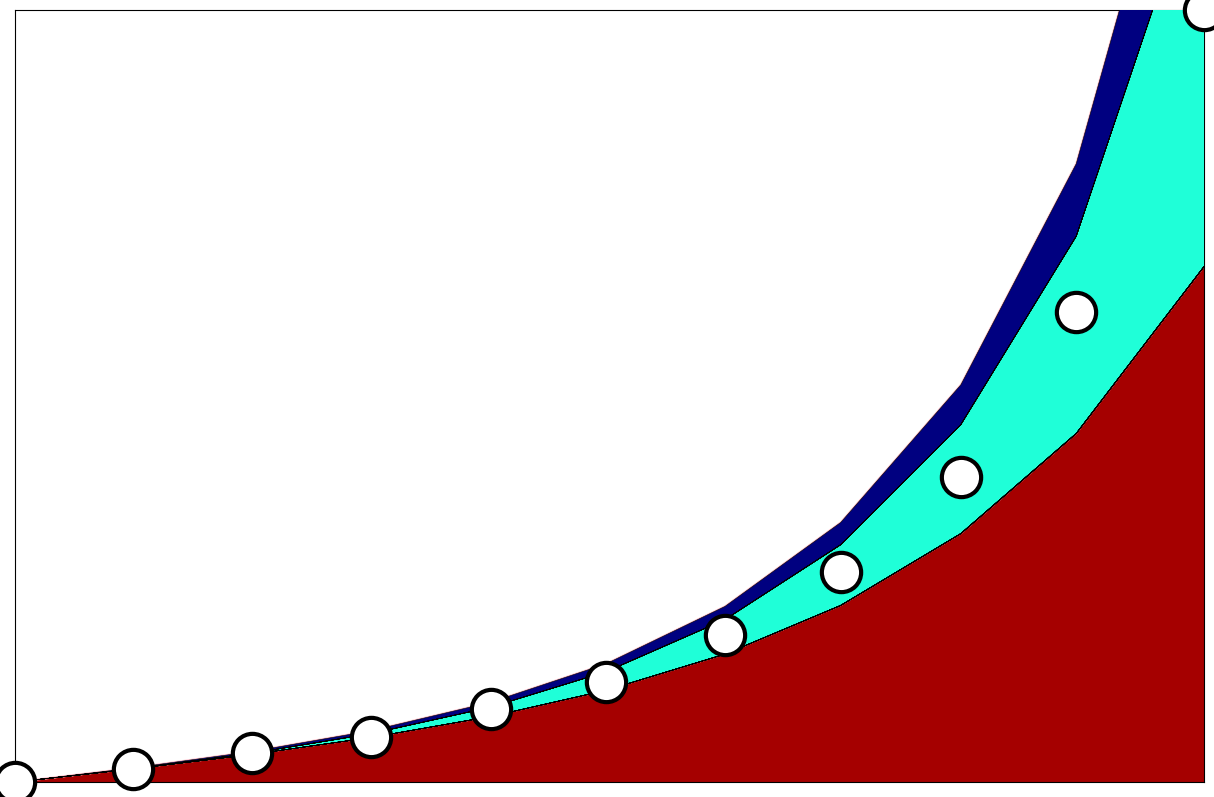

R2 ns =  0.7801322587066489


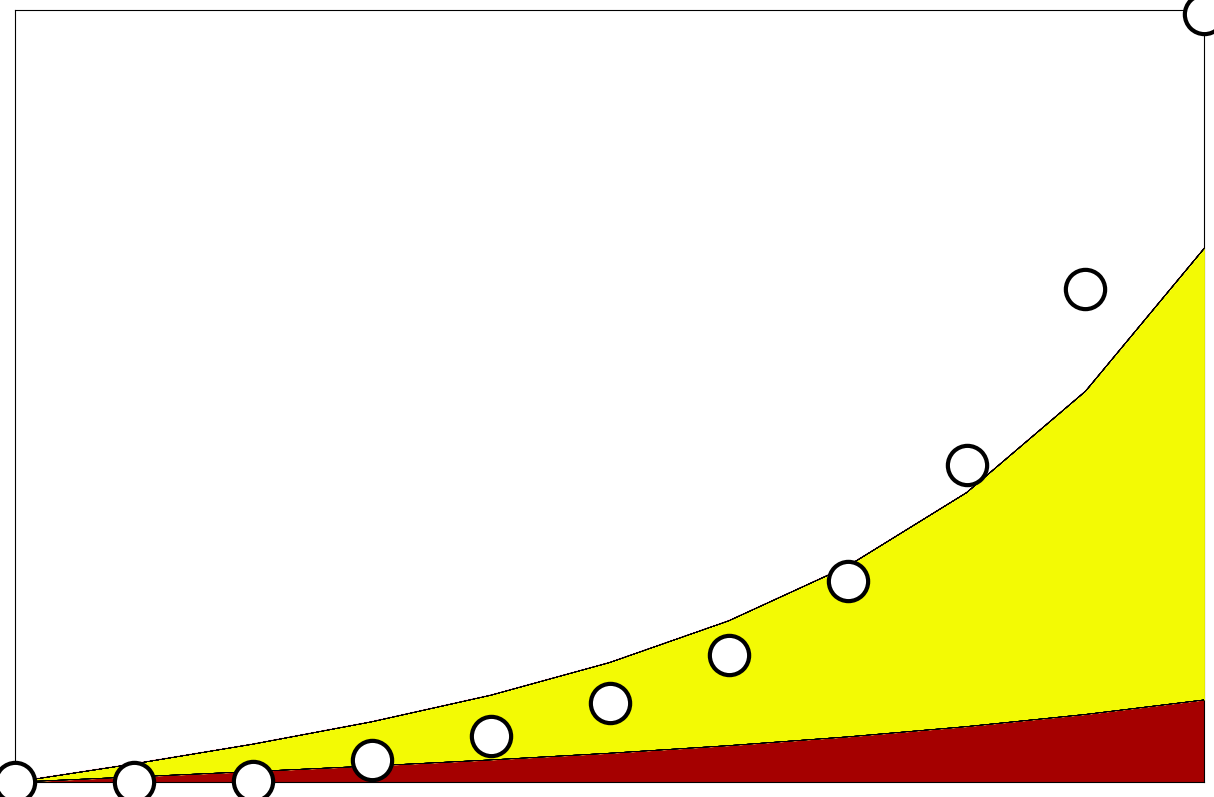

R2_1010_f =  0.8797837471577903


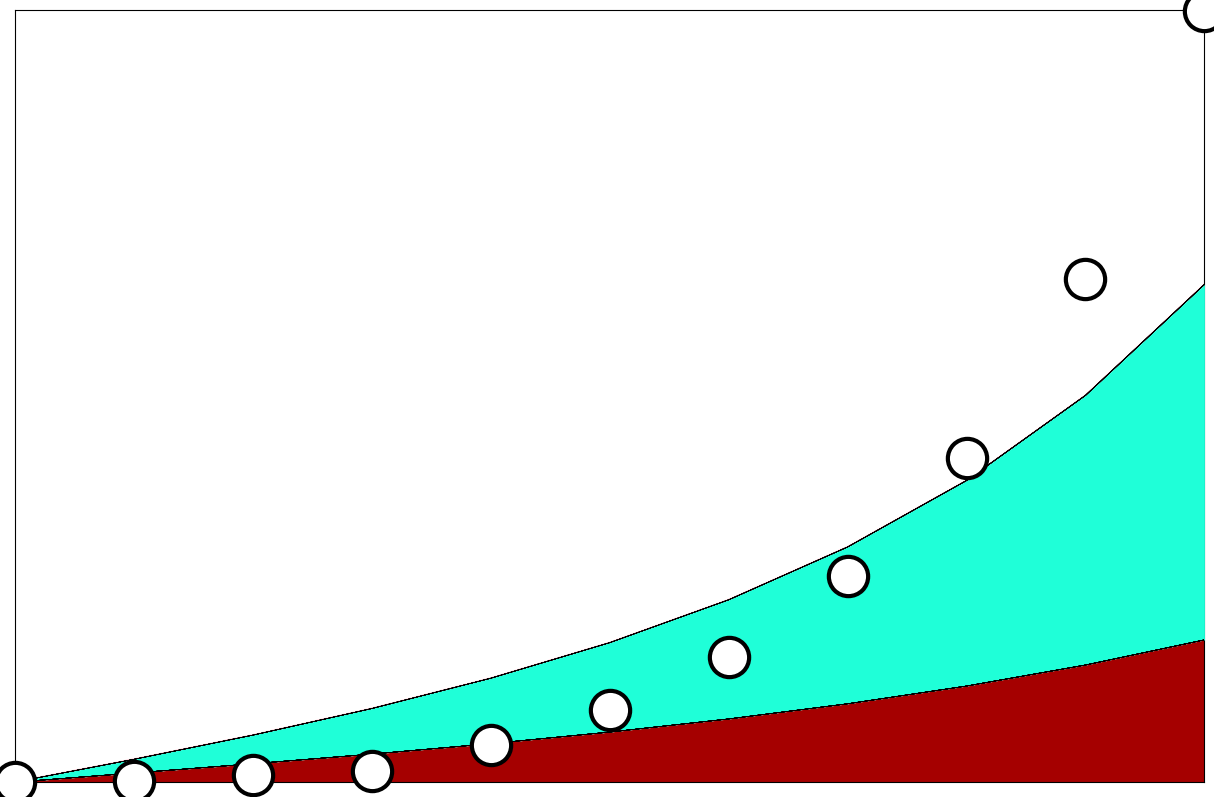

R2_1010_n =  0.8295074958712728


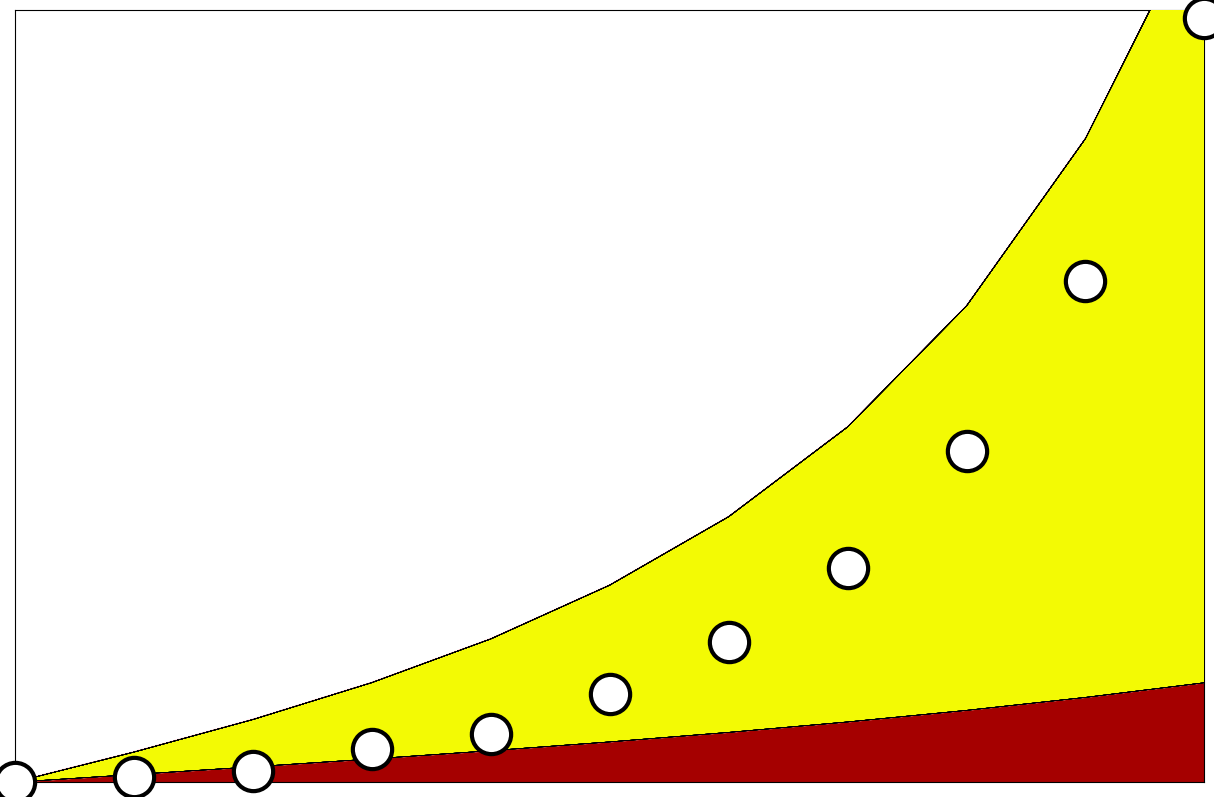

R2_1005_f =  0.8042750531814187


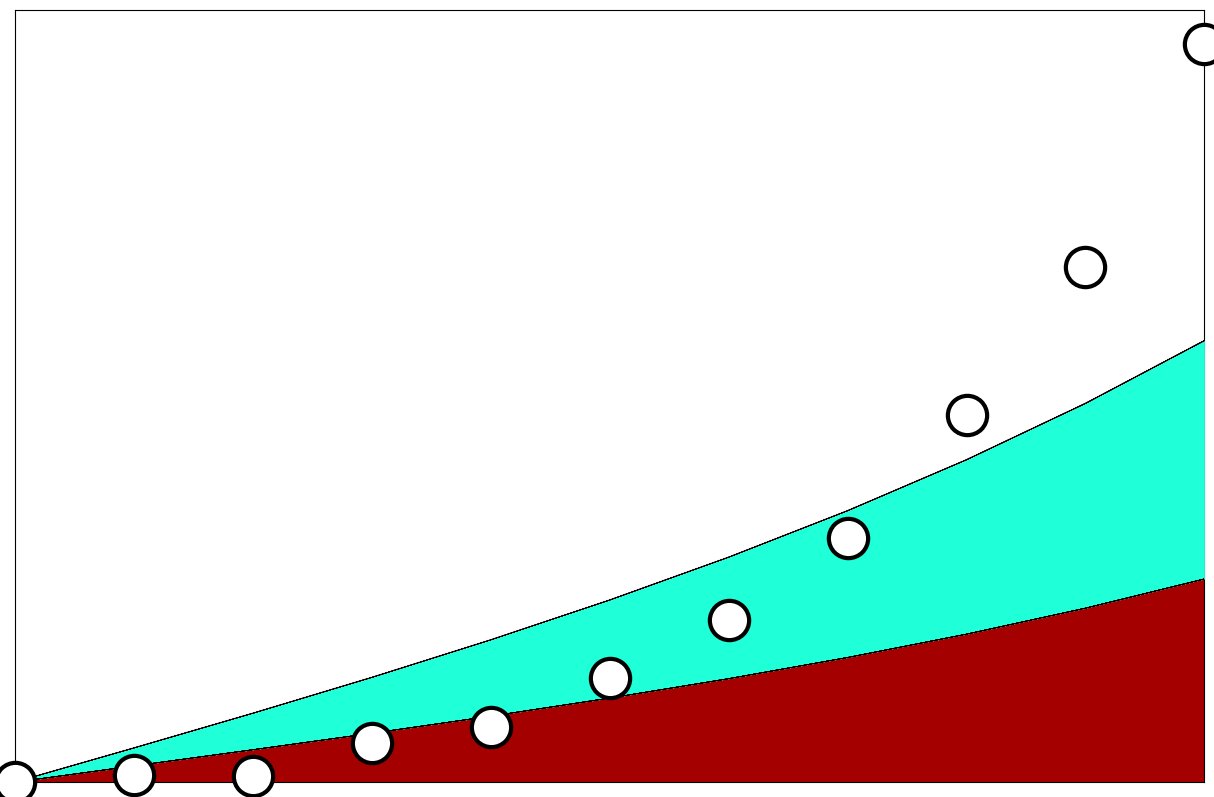

R2_1005_n =  0.7701556953547333


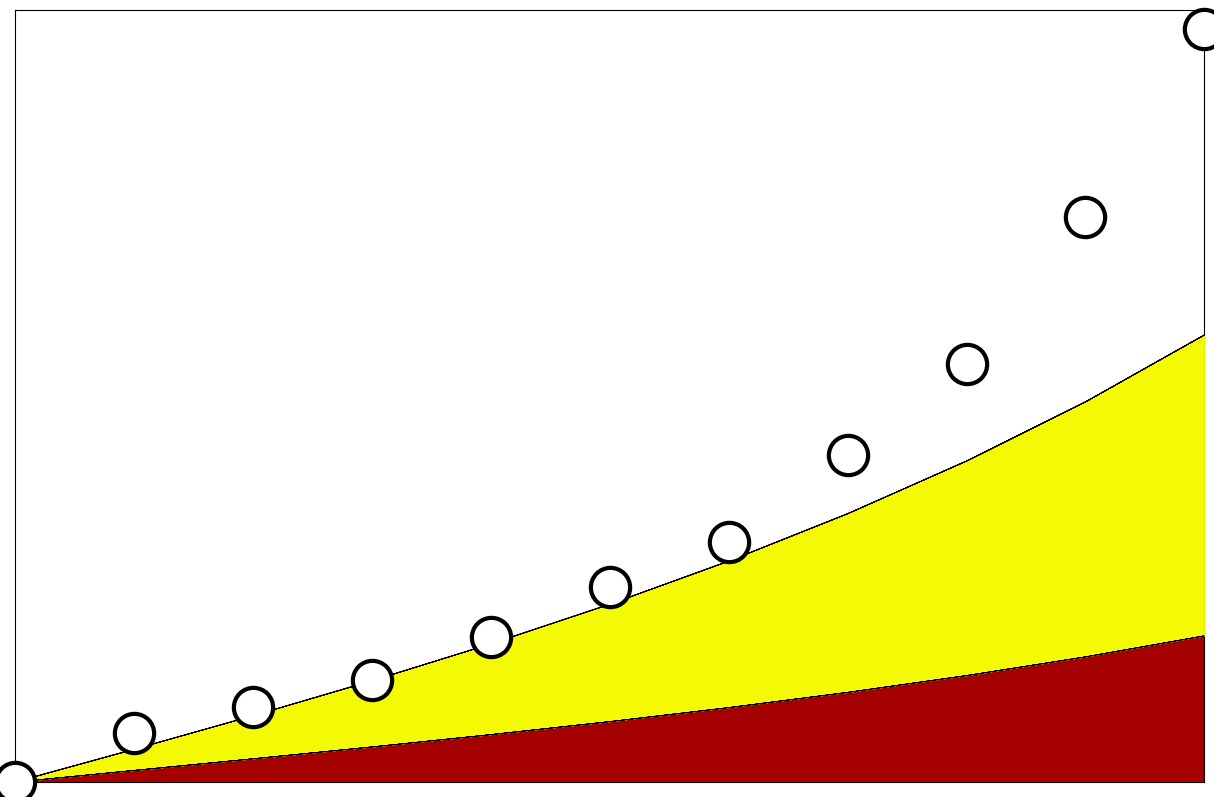

R2_0510_f =  0.7446589452138912


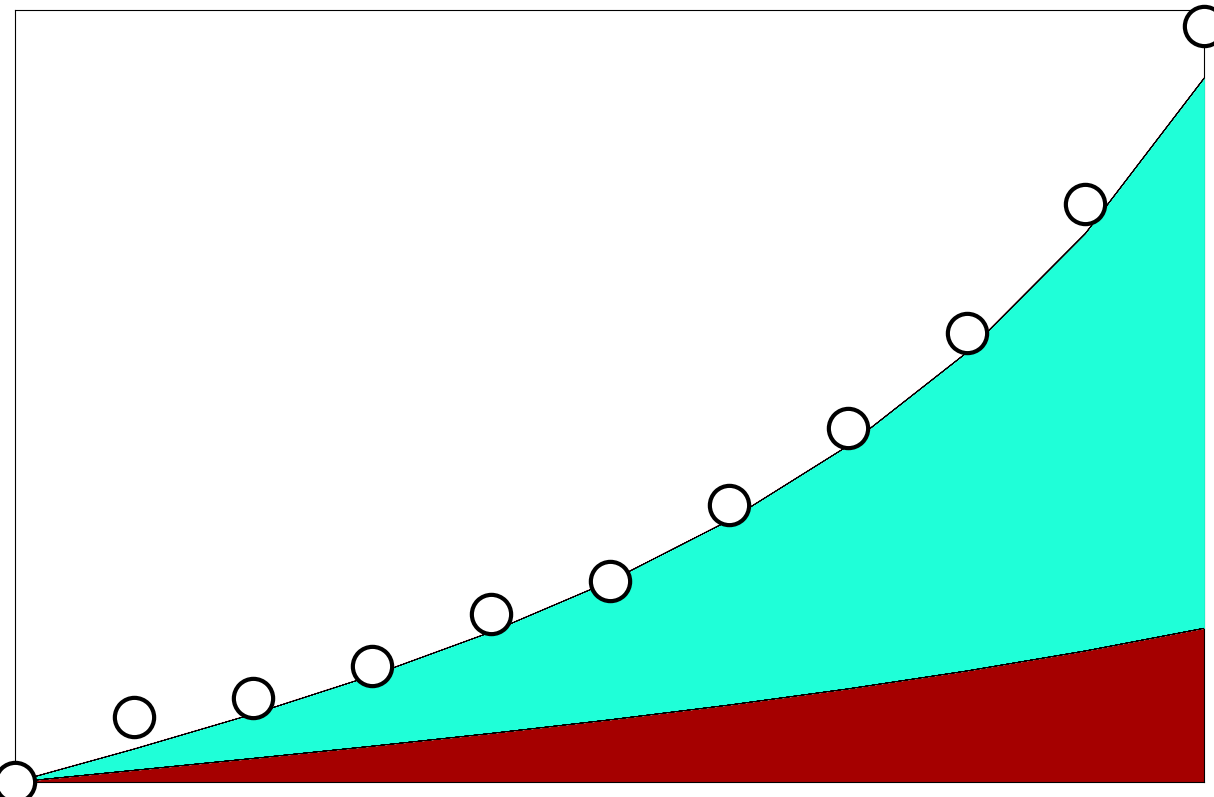

R2_0510_n =  0.988797268295236


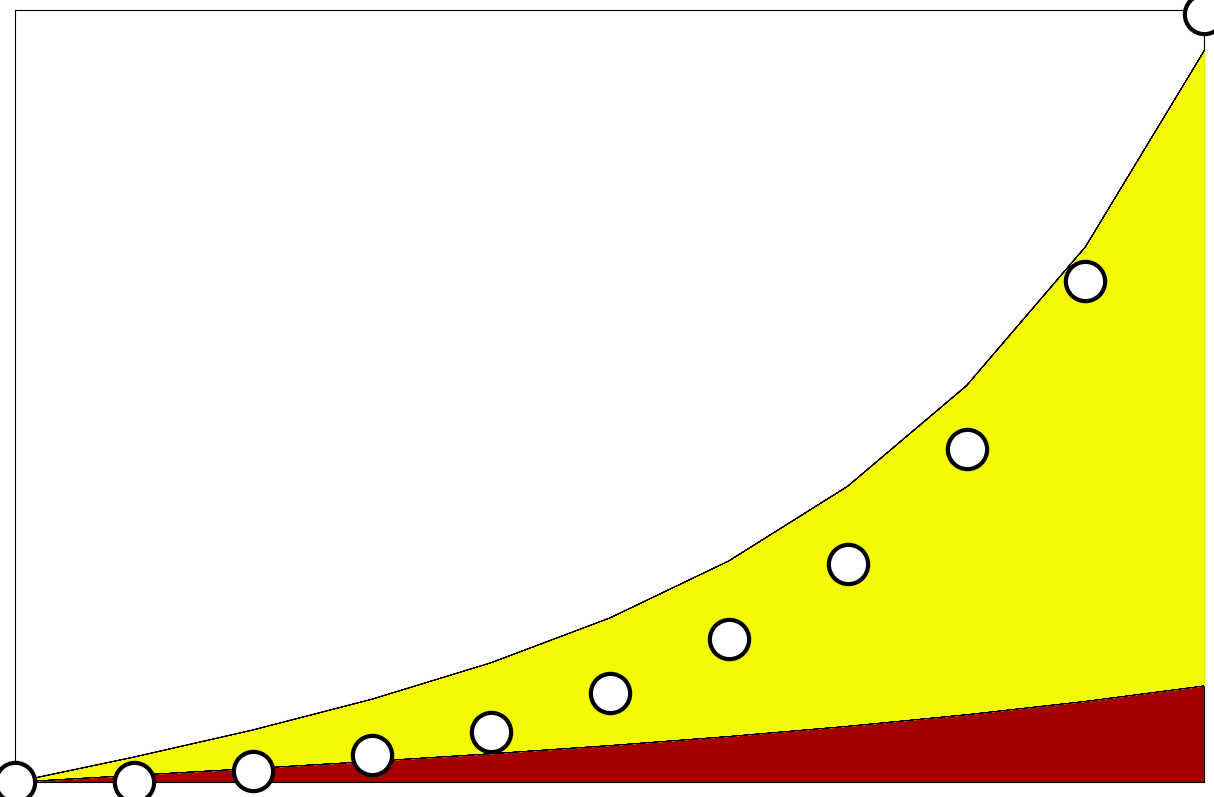

R2_1007_f =  0.9437076585766986


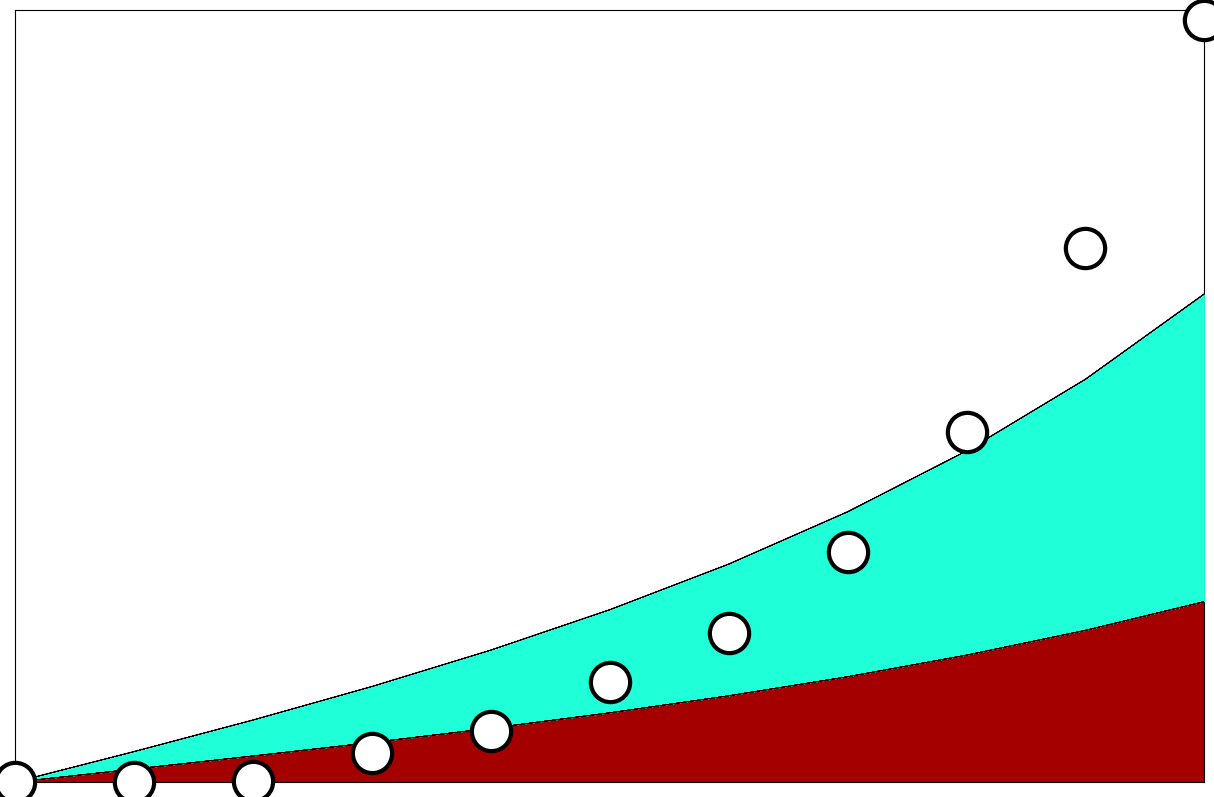

R2_1007_n =  0.8112786912607127


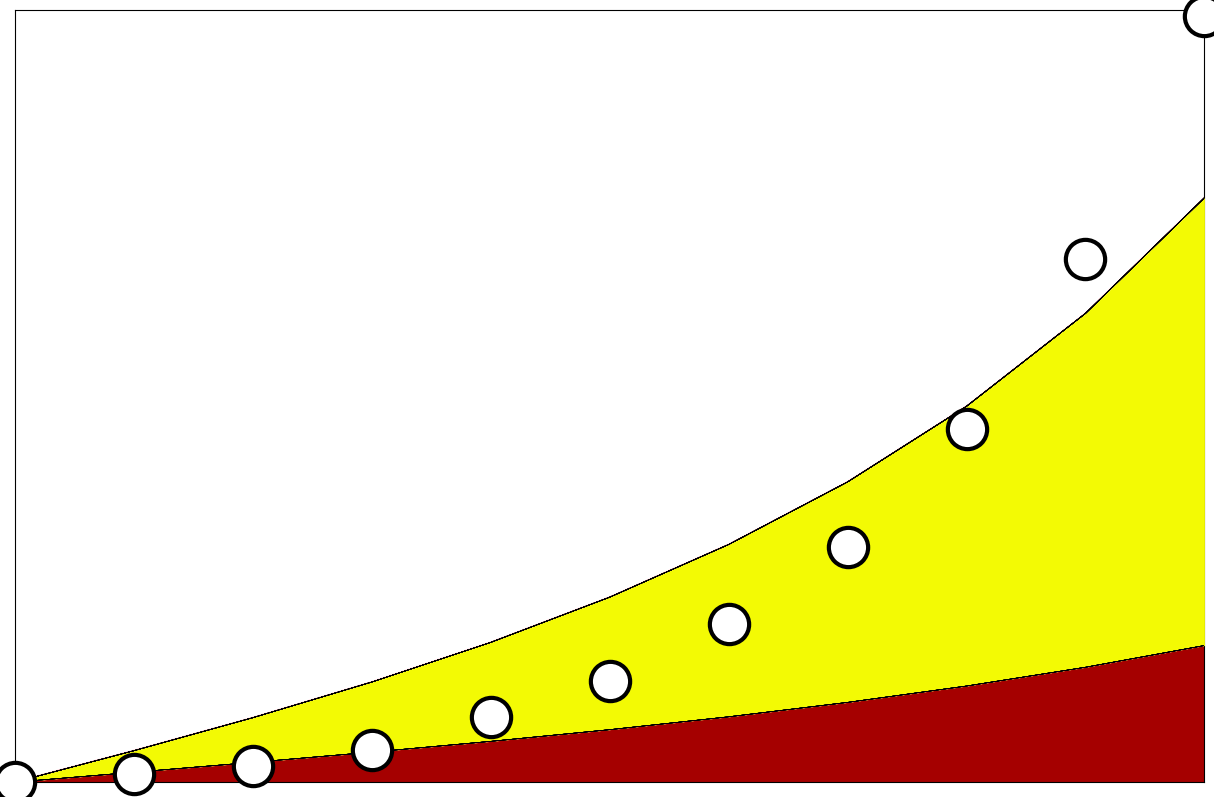

R2_0710_f =  0.8912907668866628


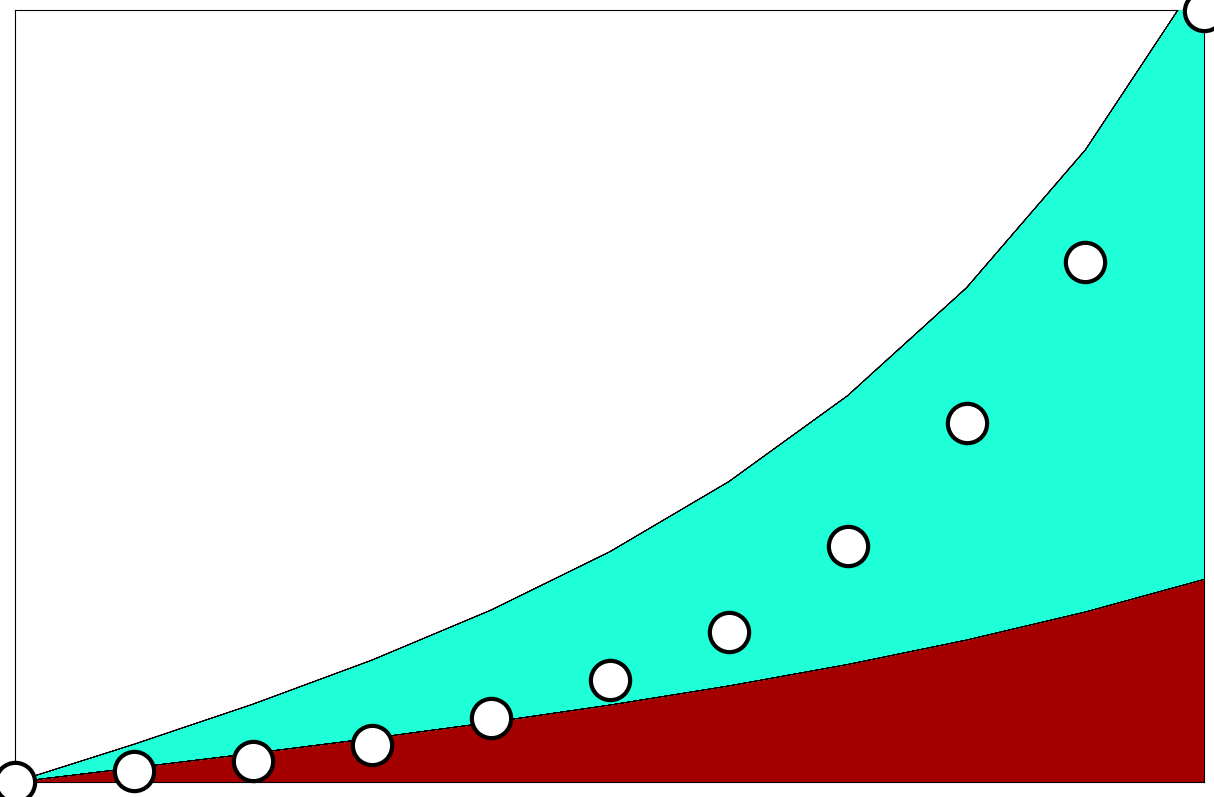

R2_0710_n =  0.8109179608511906


In [ ]:
#  Training and validation loop
count = 1
for id1, Region in enumerate(Region_all): # loop through brain region data

    #R2_all_Regions = []
    for id2, modelFit_mode in enumerate(modelFit_mode_all): # loop through model training modes

        print(40*'=')
        print("Comp {:d} / {:d}".format(count, len(Region_all)*len(modelFit_mode_all)))
        print(40*'=')
        print("Region: ", Region ,"| Fitting Mode: ", modelFit_mode)
        print(40*'=')
        count += 1

        path2saveResults = os.path.join(path2saveResults_0,Region, modelFit_mode)
        path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)

        (P_fs, gamma_fs, P_fn, gamma_fn, P_sf, gamma_sf, P_sn, gamma_sn, P_nf, gamma_nf,P_ns, gamma_ns,
        P_1010_f, stretch_1010_f, P_1010_n,stretch_1010_n,
        P_1007_f, stretch_1007_f, P_1007_n,stretch_1007_n,
        P_0710_f, stretch_0710_f, P_0710_n,stretch_0710_n,
        P_1005_f, stretch_1005_f, P_1005_n,stretch_1005_n,
        P_0510_f, stretch_0510_f, P_0510_n,stretch_0510_n) = getStressStrain(Region_test)

        # Model selection
        if model_type == 'Invariant':
            Psi_model, terms = StrainEnergyCANN_invariant(reg, pen) # build invariant-based model

        elif model_type == 'Stretch':
            Psi_model, terms = StrainEnergyCANN_stretch(reg, pen) # build principle-stretch-based model

        model_fs,model_fn,model_sf,model_sn,model_nf,model_ns,model_bi, model_bi_2,model_bi_3,model_bi_4,model_bi_5,model_sh_all,model_bi_all, model_sh_bi, Psi_model = modelArchitecture(Psi_model)
        # build uniaxial and shear models


        with open(Model_summary,'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            Psi_model.summary(line_length=80, print_fn=lambda x: fh.write(x + '\n')) # summarize layers in architecture

        #%%  Model training
        model_given, input_train, output_train, sample_weights = traindata(modelFit_mode) # model type, input/output pairs

        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights'
        path_checkpoint = path2saveResults_check + '/best_weights'
        if train: # use compile/fit parameters to train specific model (UT, SS, both) with specific input/output pairs
            model_given, history = Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint, sample_weights)

            model_given.load_weights(path_checkpoint, by_name=False, skip_mismatch=False) # load the weights saved in the path (the best ones)
            tf.keras.models.save_model(Psi_model, Save_path, overwrite=True) # save the model
            Psi_model.save_weights(Save_weights, overwrite=True) # save the weights

            # Plot loss function
            loss_history = history.history['loss']
            fig, axe = plt.subplots(figsize=[6, 5])  # inches
            plotLoss(axe, loss_history)
            plt.savefig(path2saveResults+'/Plot_loss_'+Region+'_'+modelFit_mode+'.pdf')
            plt.show()
            #plt.close()

        else: # if already trained, just load the saved weights
            Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


        # Get CANN model response

        Stress_predict_fs = model_fs.predict(gamma_fs, verbose=0)
        Stress_predict_fn = model_fn.predict(gamma_fn, verbose=0)
        Stress_predict_sf = model_sf.predict(gamma_sf, verbose=0)
        Stress_predict_sn = model_sn.predict(gamma_sn, verbose=0)
        Stress_predict_nf = model_nf.predict(gamma_nf, verbose=0)
        Stress_predict_ns = model_ns.predict(gamma_ns, verbose=0)

        Stress_predict_1010 = model_bi.predict([stretch_1010_f,stretch_1010_n], verbose=0)
        Stress_predict_1010_f = Stress_predict_1010[0][:]
        Stress_predict_1010_n = Stress_predict_1010[1][:]

        Stress_predict_1007 = model_bi.predict([stretch_1007_f,stretch_1007_n], verbose=0)
        Stress_predict_1007_f = Stress_predict_1007[0][:]
        Stress_predict_1007_n = Stress_predict_1007[1][:]

        Stress_predict_0710 = model_bi.predict([stretch_0710_f,stretch_0710_n], verbose=0)
        Stress_predict_0710_f = Stress_predict_0710[0][:]
        Stress_predict_0710_n = Stress_predict_0710[1][:]

        Stress_predict_1005 = model_bi.predict([stretch_1005_f,stretch_1005_n], verbose=0)
        Stress_predict_1005_f = Stress_predict_1005[0][:]
        Stress_predict_1005_n = Stress_predict_1005[1][:]

        Stress_predict_0510 = model_bi.predict([stretch_0510_f,stretch_0510_n], verbose=0)
        Stress_predict_0510_f = Stress_predict_0510[0][:]
        Stress_predict_0510_n = Stress_predict_0510[1][:]


        # Show weights
        if model_type == 'Stretch':
            weight_matrix = np.empty((terms, 1))
            for i in range(terms):
                value = Psi_model.get_weights()[i]
                weight_matrix[i] = value
            print("weight_matrix")
            print(*weight_matrix, sep="\n")

        elif model_type == 'Invariant':
            weight_matrix = np.empty((terms, 2))
            for i in range(terms):
                value = Psi_model.get_weights()[i][0][0]
                weight_matrix[i, 0] = value
                weight_matrix[:, 1] = Psi_model.get_layer('wx2').get_weights()[0].flatten()
            print("weight_matrix")
            print(weight_matrix)

        # Get the trained weights
        model_weights_0 = Psi_model.get_weights()

        #print R2
        R2_fs = r2_score(P_fs, Stress_predict_fs)
        print('R2 fs = ', R2_fs)

        R2_fn = r2_score(P_fn, Stress_predict_fn)
        print('R2 fn = ', R2_fn)

        R2_sf = r2_score(P_sf, Stress_predict_sf)
        print('R2 sf = ', R2_sf)

        R2_sn = r2_score(P_sn, Stress_predict_sn)
        print('R2 sn = ', R2_sn)

        R2_nf = r2_score(P_nf, Stress_predict_nf)
        print('R2 nf = ', R2_nf)

        R2_ns = r2_score(P_ns, Stress_predict_ns)
        print('R2 ns = ', R2_ns)

        R2_1010_f = r2_score(P_1010_f, Stress_predict_1010_f)
        print('R2_1010_f = ', R2_1010_f)

        R2_1010_n = r2_score(P_1010_n, Stress_predict_1010_n)
        print('R2_1010_n = ', R2_1010_n)

        R2_1005_f = r2_score(P_1005_f, Stress_predict_1005_f)
        print('R2_1005_f = ', R2_1005_f)

        R2_1005_n = r2_score(P_1005_n, Stress_predict_1005_n)
        print('R2_1005_n = ', R2_1005_n)

        R2_0510_f = r2_score(P_0510_f, Stress_predict_0510_f)
        print('R2_0510_f = ', R2_0510_f)

        R2_0510_n = r2_score(P_0510_n, Stress_predict_0510_n)
        print('R2_0510_n = ', R2_0510_n)

        R2_1007_f = r2_score(P_1007_f, Stress_predict_1007_f)
        print('R2_1007_f = ', R2_1007_f)

        R2_1007_n = r2_score(P_1007_n, Stress_predict_1007_n)
        print('R2_1007_n = ', R2_1007_n)

        R2_0710_f = r2_score(P_0710_f, Stress_predict_0710_f)
        print('R2_0710_f = ', R2_0710_f)

        R2_0710_n = r2_score(P_0710_n, Stress_predict_0710_n)
        print('R2_0710_n = ', R2_0710_n)

        R2_total = 1./16*(R2_fs + R2_fn + R2_sf + R2_sn+ R2_nf+ R2_ns + R2_1010_f + R2_1010_n+ R2_1007_f+ R2_1007_n + R2_0710_f + R2_0710_n + R2_1005_f+ R2_1005_n + R2_0510_f + R2_0510_n)
        print('R2_total = ', R2_total)

        #print rms

        rms_fs = mean_squared_error(P_fs, Stress_predict_fs, squared=False)
        print('rms fs = ', rms_fs)

        rms_fn = mean_squared_error(P_fn, Stress_predict_fn, squared=False)
        print('rms fn = ', rms_fn)

        rms_sf = mean_squared_error(P_sf, Stress_predict_sf, squared=False)
        print('rms sf = ', rms_sf)

        rms_sn = mean_squared_error(P_sn, Stress_predict_sn, squared=False)
        print('rms sn = ', rms_sn)

        rms_nf = mean_squared_error(P_nf, Stress_predict_nf, squared=False)
        print('rms nf = ', rms_nf)

        rms_ns = mean_squared_error(P_ns, Stress_predict_ns, squared=False)
        print('rms ns = ', rms_ns)

        rms_1010_f = mean_squared_error(P_1010_f, Stress_predict_1010_f, squared=False)
        print('rms_1010_f = ', rms_1010_f)

        rms_1010_n = mean_squared_error(P_1010_n, Stress_predict_1010_n, squared=False)
        print('rms_1010_n = ', rms_1010_n)

        rms_1005_f = mean_squared_error(P_1005_f, Stress_predict_1005_f, squared=False)
        print('rms_1005_f = ', rms_1005_f)

        rms_1005_n = mean_squared_error(P_1005_n, Stress_predict_1005_n, squared=False)
        print('rms_1005_n = ', rms_1005_n)

        rms_0510_f = mean_squared_error(P_0510_f, Stress_predict_0510_f, squared=False)
        print('rms_0510_f = ', rms_0510_f)

        rms_0510_n = mean_squared_error(P_0510_n, Stress_predict_0510_n, squared=False)
        print('rms_0510_n = ', rms_0510_n)

        rms_1007_f = mean_squared_error(P_1007_f, Stress_predict_1007_f, squared=False)
        print('rms_1007_f = ', rms_1007_f)

        rms_1007_n = mean_squared_error(P_1007_n, Stress_predict_1007_n, squared=False)
        print('rms_1007_n = ', rms_1007_n)

        rms_0710_f = mean_squared_error(P_0710_f, Stress_predict_0710_f, squared=False)
        print('rms_0710_f = ', rms_0710_f)

        rms_0710_n = mean_squared_error(P_0710_n, Stress_predict_0710_n, squared=False)
        print('rms_0710_n = ', rms_0710_n)

        rms_total = 1./16*(rms_fs + rms_fn + rms_sf + rms_sn+ rms_nf+ rms_ns + rms_1010_f + rms_1010_n+ R2_1007_f+ rms_1007_n + rms_0710_f + rms_0710_n + rms_1005_f+ R2_1005_n + rms_0510_f + rms_0510_n)
        print('rms_total = ', rms_total)

         # Plot the contributions of each term to the output of the model
        fig, ax = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear fs")
        plt.scatter(gamma_fs, P_fs,color='red')
        plt.plot(gamma_fs, Stress_predict_fs,color='pink')
        plotMapShear(ax, Psi_model, model_weights_0, model_fs, terms, gamma_fs, P_fs, Region,
                             path2saveResults, modelFit_mode, model_type,'fs')
        R2_fs = r2_score(P_fs, Stress_predict_fs)
        print('R2 fs = ', R2_fs)

        fig2, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear fn")
        plt.scatter(gamma_fn, P_fn,color='red')
        plt.plot(gamma_fn, Stress_predict_fn,color='pink')
        plotMapShear(ax3, Psi_model, model_weights_0, model_fn, terms, gamma_fn, P_fn, Region,
                             path2saveResults, modelFit_mode, model_type,'fn')
        R2_fn = r2_score(P_fn, Stress_predict_fn)
        print('R2 fn = ', R2_fn)

        fig3, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear sf")
        plt.scatter(gamma_sf, P_sf,color='red')
        plt.plot(gamma_sf, Stress_predict_sf,color='pink')
        plotMapShear(ax3, Psi_model, model_weights_0, model_sf, terms, gamma_sf, P_sf, Region,
                              path2saveResults, modelFit_mode, model_type,'sf')
        R2_sf = r2_score(P_sf, Stress_predict_sf)
        print('R2 sf = ', R2_sf)

        fig4, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear sn")
        plt.scatter(gamma_sn, P_sn,color='red')
        plt.plot(gamma_sn, Stress_predict_sn,color='pink')
        plotMapShear(ax3, Psi_model, model_weights_0, model_sn, terms, gamma_sn, P_sn, Region,
                              path2saveResults, modelFit_mode, model_type, 'sn')
        R2_sn = r2_score(P_sn, Stress_predict_sn)
        print('R2 sn = ', R2_sn)

        fig5, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear nf")
        plt.scatter(gamma_nf, P_nf,color='red')
        plt.plot(gamma_nf, Stress_predict_nf,color='pink')
        plotMapShear(ax3, Psi_model, model_weights_0, model_nf, terms, gamma_nf, P_nf, Region,
                              path2saveResults, modelFit_mode, model_type,'nf')
        R2_nf = r2_score(P_nf, Stress_predict_nf)
        print('R2 nf = ', R2_nf)

        fig6, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("shear ns")
        plt.scatter(gamma_ns, P_ns,color='red')
        plt.plot(gamma_ns, Stress_predict_ns,color='pink')
        plotMapShear(ax3, Psi_model, model_weights_0, model_ns, terms, gamma_ns, P_ns, Region,
                              path2saveResults, modelFit_mode, model_type,'ns')
        R2_ns = r2_score(P_ns, Stress_predict_ns)
        print('R2 ns = ', R2_ns)

        ##biaxial 1:1
        fig7, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:1 f")
        #plt.scatter(stretch_1010_f, P_1010_f,color='red')
        plt.plot(stretch_1010_f, Stress_predict_1010_f,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1010_f,stretch_1010_n,stretch_1010_f, P_1010_f, Region,
                              path2saveResults, modelFit_mode, model_type,'x','1010x')
        R2_1010_f = r2_score(P_1010_f, Stress_predict_1010_f)
        print('R2_1010_f = ', R2_1010_f)

        fig8, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:1 n")
        plt.scatter(stretch_1010_n, P_1010_n,color='red')
        plt.plot(stretch_1010_n, Stress_predict_1010_n,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1010_f,stretch_1010_n,stretch_1010_n, P_1010_n, Region,
                             path2saveResults, modelFit_mode, model_type,'y','1010y')
        R2_1010_n = r2_score(P_1010_n, Stress_predict_1010_n)
        print('R2_1010_n = ', R2_1010_n)

        ##biaxial 1:05
        fig9, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:0.5 f")
        plt.scatter(stretch_1005_f, P_1005_f,color='red')
        plt.plot(stretch_1005_f, Stress_predict_1005_f,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1005_f,stretch_1005_n,stretch_1005_f, P_1005_f, Region,
                              path2saveResults, modelFit_mode, model_type,'x','1005x')
        R2_1005_f = r2_score(P_1005_f, Stress_predict_1005_f)
        print('R2_1005_f = ', R2_1005_f)

        fig10, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:0.5 n")
        plt.scatter(stretch_1005_n, P_1005_n,color='red')
        plt.plot(stretch_1005_n, Stress_predict_1005_n,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1005_f,stretch_1005_n,stretch_1005_n, P_1005_n, Region,
                             path2saveResults, modelFit_mode, model_type,'y','1005y')
        R2_1005_n = r2_score(P_1005_n, Stress_predict_1005_n)
        print('R2_1005_n = ', R2_1005_n)

        ##biaxial 05:1
        fig11, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 0.5:1 f")
        plt.scatter(stretch_0510_f, P_0510_f,color='red')
        plt.plot(stretch_0510_f, Stress_predict_0510_f,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_0510_f,stretch_0510_n,stretch_0510_f, P_0510_f, Region,
                             path2saveResults, modelFit_mode, model_type,'x','0510x')
        R2_0510_f = r2_score(P_0510_f, Stress_predict_0510_f)
        print('R2_0510_f = ', R2_0510_f)

        fig12, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 0.5:1 n")
        plt.scatter(stretch_0510_n, P_0510_n,color='red')
        plt.plot(stretch_0510_n, Stress_predict_0510_n,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_0510_f,stretch_0510_n,stretch_0510_n, P_0510_n, Region,
                              path2saveResults, modelFit_mode, model_type,'y','0510y')
        R2_0510_n = r2_score(P_0510_n, Stress_predict_0510_n)
        print('R2_0510_n = ', R2_0510_n)

        ##biaxial 1:075
        fig13, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:075 f")
        plt.scatter(stretch_1007_f, P_1007_f,color='red')
        plt.plot(stretch_1007_f, Stress_predict_1007_f,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1007_f,stretch_1007_n,stretch_1007_f, P_1007_f, Region,
                              path2saveResults, modelFit_mode, model_type,'x','1007x')
        R2_1007_f = r2_score(P_1007_f, Stress_predict_1007_f)
        print('R2_1007_f = ', R2_1007_f)

        fig14, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 1:075 n")
        plt.scatter(stretch_1007_n, P_1007_n,color='red')
        plt.plot(stretch_1007_n, Stress_predict_1007_n,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_1007_f,stretch_1007_n,stretch_1007_n, P_1007_n, Region,
                              path2saveResults, modelFit_mode, model_type,'y','1007y')
        R2_1007_n = r2_score(P_1007_n, Stress_predict_1007_n)
        print('R2_1007_n = ', R2_1007_n)

        ##biaxial 075:1
        fig15, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 075:1 f")
        plt.scatter(stretch_0710_f, P_0710_f,color='red')
        plt.plot(stretch_0710_f, Stress_predict_0710_f,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_0710_f,stretch_0710_n,stretch_0710_f, P_0710_f, Region,
                              path2saveResults, modelFit_mode, model_type,'x','0710x')
        R2_0710_f = r2_score(P_0710_f, Stress_predict_0710_f)
        print('R2_0710_f = ', R2_0710_f)

        fig16, ax3 = plt.subplots(figsize=(12.5, 8.33))
        #plt.title("biaxial 075:1 n")
        plt.scatter(stretch_0710_n, P_0710_n,color='red')
        plt.plot(stretch_0710_n, Stress_predict_0710_n,color='pink')
        plotMapBi(ax3, Psi_model, model_weights_0, model_bi, terms, stretch_0710_f,stretch_0710_n,stretch_0710_n, P_0710_n, Region,
                             path2saveResults, modelFit_mode, model_type,'y','0710y')
        R2_0710_n = r2_score(P_0710_n, Stress_predict_0710_n)
        print('R2_0710_n = ', R2_0710_n)


        # Save trained weights and R2 values to txt file
        Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_fs": R2_fs,
                    "weights": weight_matrix.tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))